# Análise de Causalidade e Estabilidade em Ambiente Multi-Tenant

Este notebook documenta a análise de dados completa, desde a identificação do impacto inicial até a criação de análises de risco avançadas.

**Roteiro da Análise:**
1.  **Carregamento e Inspeção Inicial dos Dados**
2.  **Análise de Impacto: Identificando as "Vítimas"**
3.  **Análise de Causalidade Direcional (Heatmaps)**
4.  **Análise Espectral para Quantificar o "Pânico Sistêmico"**
5.  **Criação do Dataset de Inteligência (`analise_avancada.csv`)**
6.  **Análise de Risco e Priorização: Os "Mais Procurados"**
7.  **Análise Investigativa Profunda: Os "Casos Arquivados"**

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Padronização global de estilo e resolução dos plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

# Carrega todos os dataframes
try:
    causality_all_df = pd.read_csv('./outputs/sfi2-long/default_experiment/multi_round_analysis/multi_round_causality_all.csv')
    correlation_all_df = pd.read_csv('./outputs/sfi2-long/default_experiment/multi_round_analysis/multi_round_correlation_all.csv')
    impact_stats_df = pd.read_csv('./outputs/sfi2-long/default_experiment/multi_round_analysis/multi_round_impact_aggregated_stats.csv')
    print("Arquivos iniciais carregados com sucesso!")
except FileNotFoundError as e:
    print(f"Erro ao carregar arquivos: {e}. \nVerifique se os arquivos CSV estão no mesmo diretório que este notebook.")

Arquivos iniciais carregados com sucesso!


In [19]:
# Dicionário de nomes elegantes para métricas
METRIC_DISPLAY_NAMES = {
    'cpu_usage': 'Uso de CPU (%)',
    'memory_usage': 'Uso de Memória (B)',
    'disk_usage': 'Uso de Disco (%)',
    'network_receive': 'Banda Total de Rede (MB/s)',
    'disk_io_total': 'Vazão Total de Disco (B/s)',
    # Adicione outras métricas conforme necessário
}

def get_metric_display_name(metric):
    """Retorna o nome elegante da métrica para exibição."""
    return METRIC_DISPLAY_NAMES.get(metric, metric)

## 1. Análise de Impacto: Identificando as "Vítimas"

A primeira análise busca entender o tamanho do dano. O gráfico abaixo mostra a **mudança percentual média** no desempenho de cada tenant para as diferentes métricas.

As barras negativas representam uma degradação na performance. Foi este gráfico que forneceu a primeira pista de que `tenant-cpu`, `tenant-ntk`, `tenant-dsk` e `tenant-mem` sofriam impactos brutais em suas respectivas métricas principais.

Gerando gráfico de Análise de Impacto...


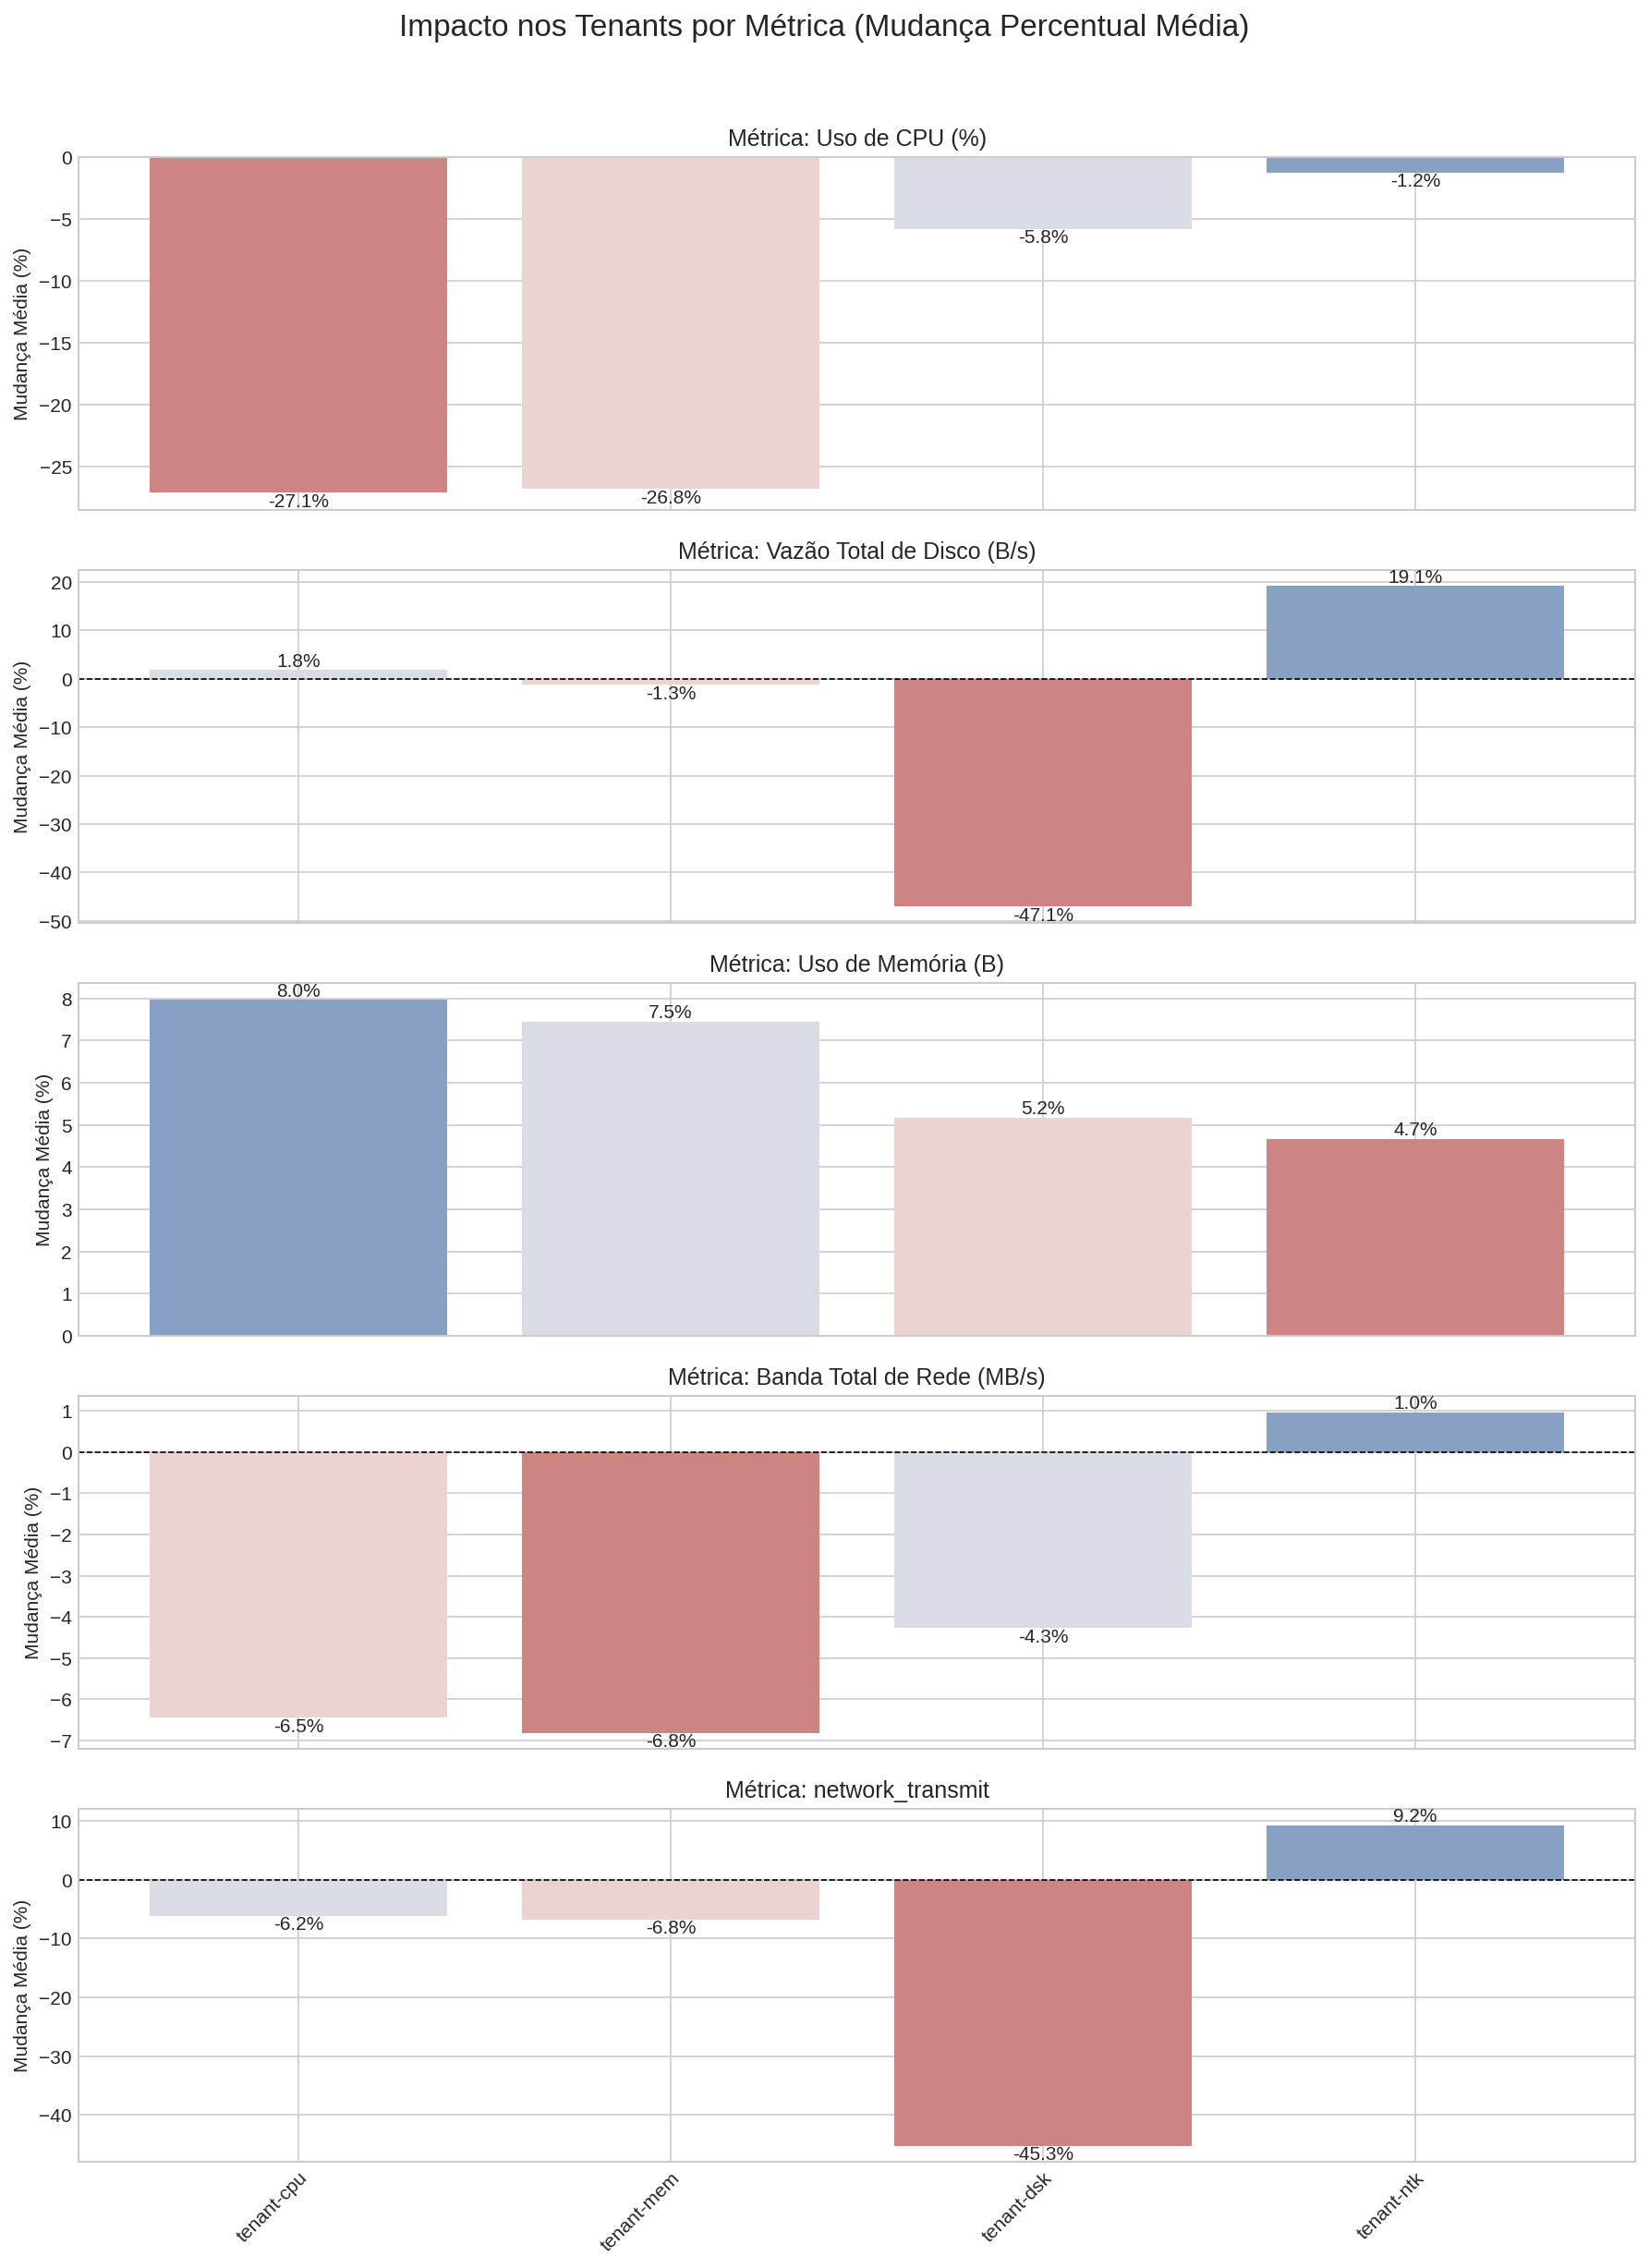

In [20]:
# Gráfico de Barras do Impacto (Mudança Percentual Média)
print("Gerando gráfico de Análise de Impacto...")

fig, axes = plt.subplots(nrows=len(impact_stats_df['metric_name'].unique()), ncols=1, figsize=(12, 16), sharex=True)
fig.suptitle('Impacto nos Tenants por Métrica (Mudança Percentual Média)', fontsize=16, y=1.02)

metrics = impact_stats_df['metric_name'].unique()
for i, metric in enumerate(metrics):
    ax = axes[i]
    metric_df = impact_stats_df[impact_stats_df['metric_name'] == metric].sort_values('mean_percentage_change')
    
    # Usando uma paleta de cores divergente para destacar positivos e negativos
    palette = sns.color_palette("vlag_r", len(metric_df))
    bars = ax.bar(metric_df['tenant_id'], metric_df['mean_percentage_change'], color=palette)
    
    ax.set_ylabel('Mudança Média (%)')
    ax.set_title(f'Métrica: {get_metric_display_name(metric)}')
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Adiciona os rótulos nas barras
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f}%', va='bottom' if yval >=0 else 'top', ha='center')

plt.tight_layout(rect=(0, 0, 1, 1))
plt.show()

#### Interpretação dos Resultados


É interessante ver que Disco (dsk) e Memória (mem) estão no topo. Aparentemente, em ambientes de nuvem e microserviços, é muito comum que a contenção de I/O (disco e rede) e a pressão sobre a memória sejam as fontes mais traiçoeiras de problemas de performance. A CPU costuma ser mais bem "isolada" entre os processos, mas I/O e memória podem gerar gargalos que afetam todo o host. Os dados parecem confirmar essa suspeita. tenant-nsy é o menos "barulhento", mas ainda assim relevante.

## 2. Análise de Causalidade: Desvendando o Efeito Dominó

A seguir, visualizamos como a interferência se propaga. Usamos heatmaps para mostrar a frequência de links causais significantes (`p-value < 0.05` ou `score` acima do 75º percentil) entre os tenants em cada fase experimental.

**Observação Chave:** O ciclo vicioso entre **Disco (`dsk`) e Memória (`mem`)** é evidente em quase todas as fases, atuando como a principal "avenida" para a propagação do caos.

Gerando Heatmaps de Causalidade Direcional...


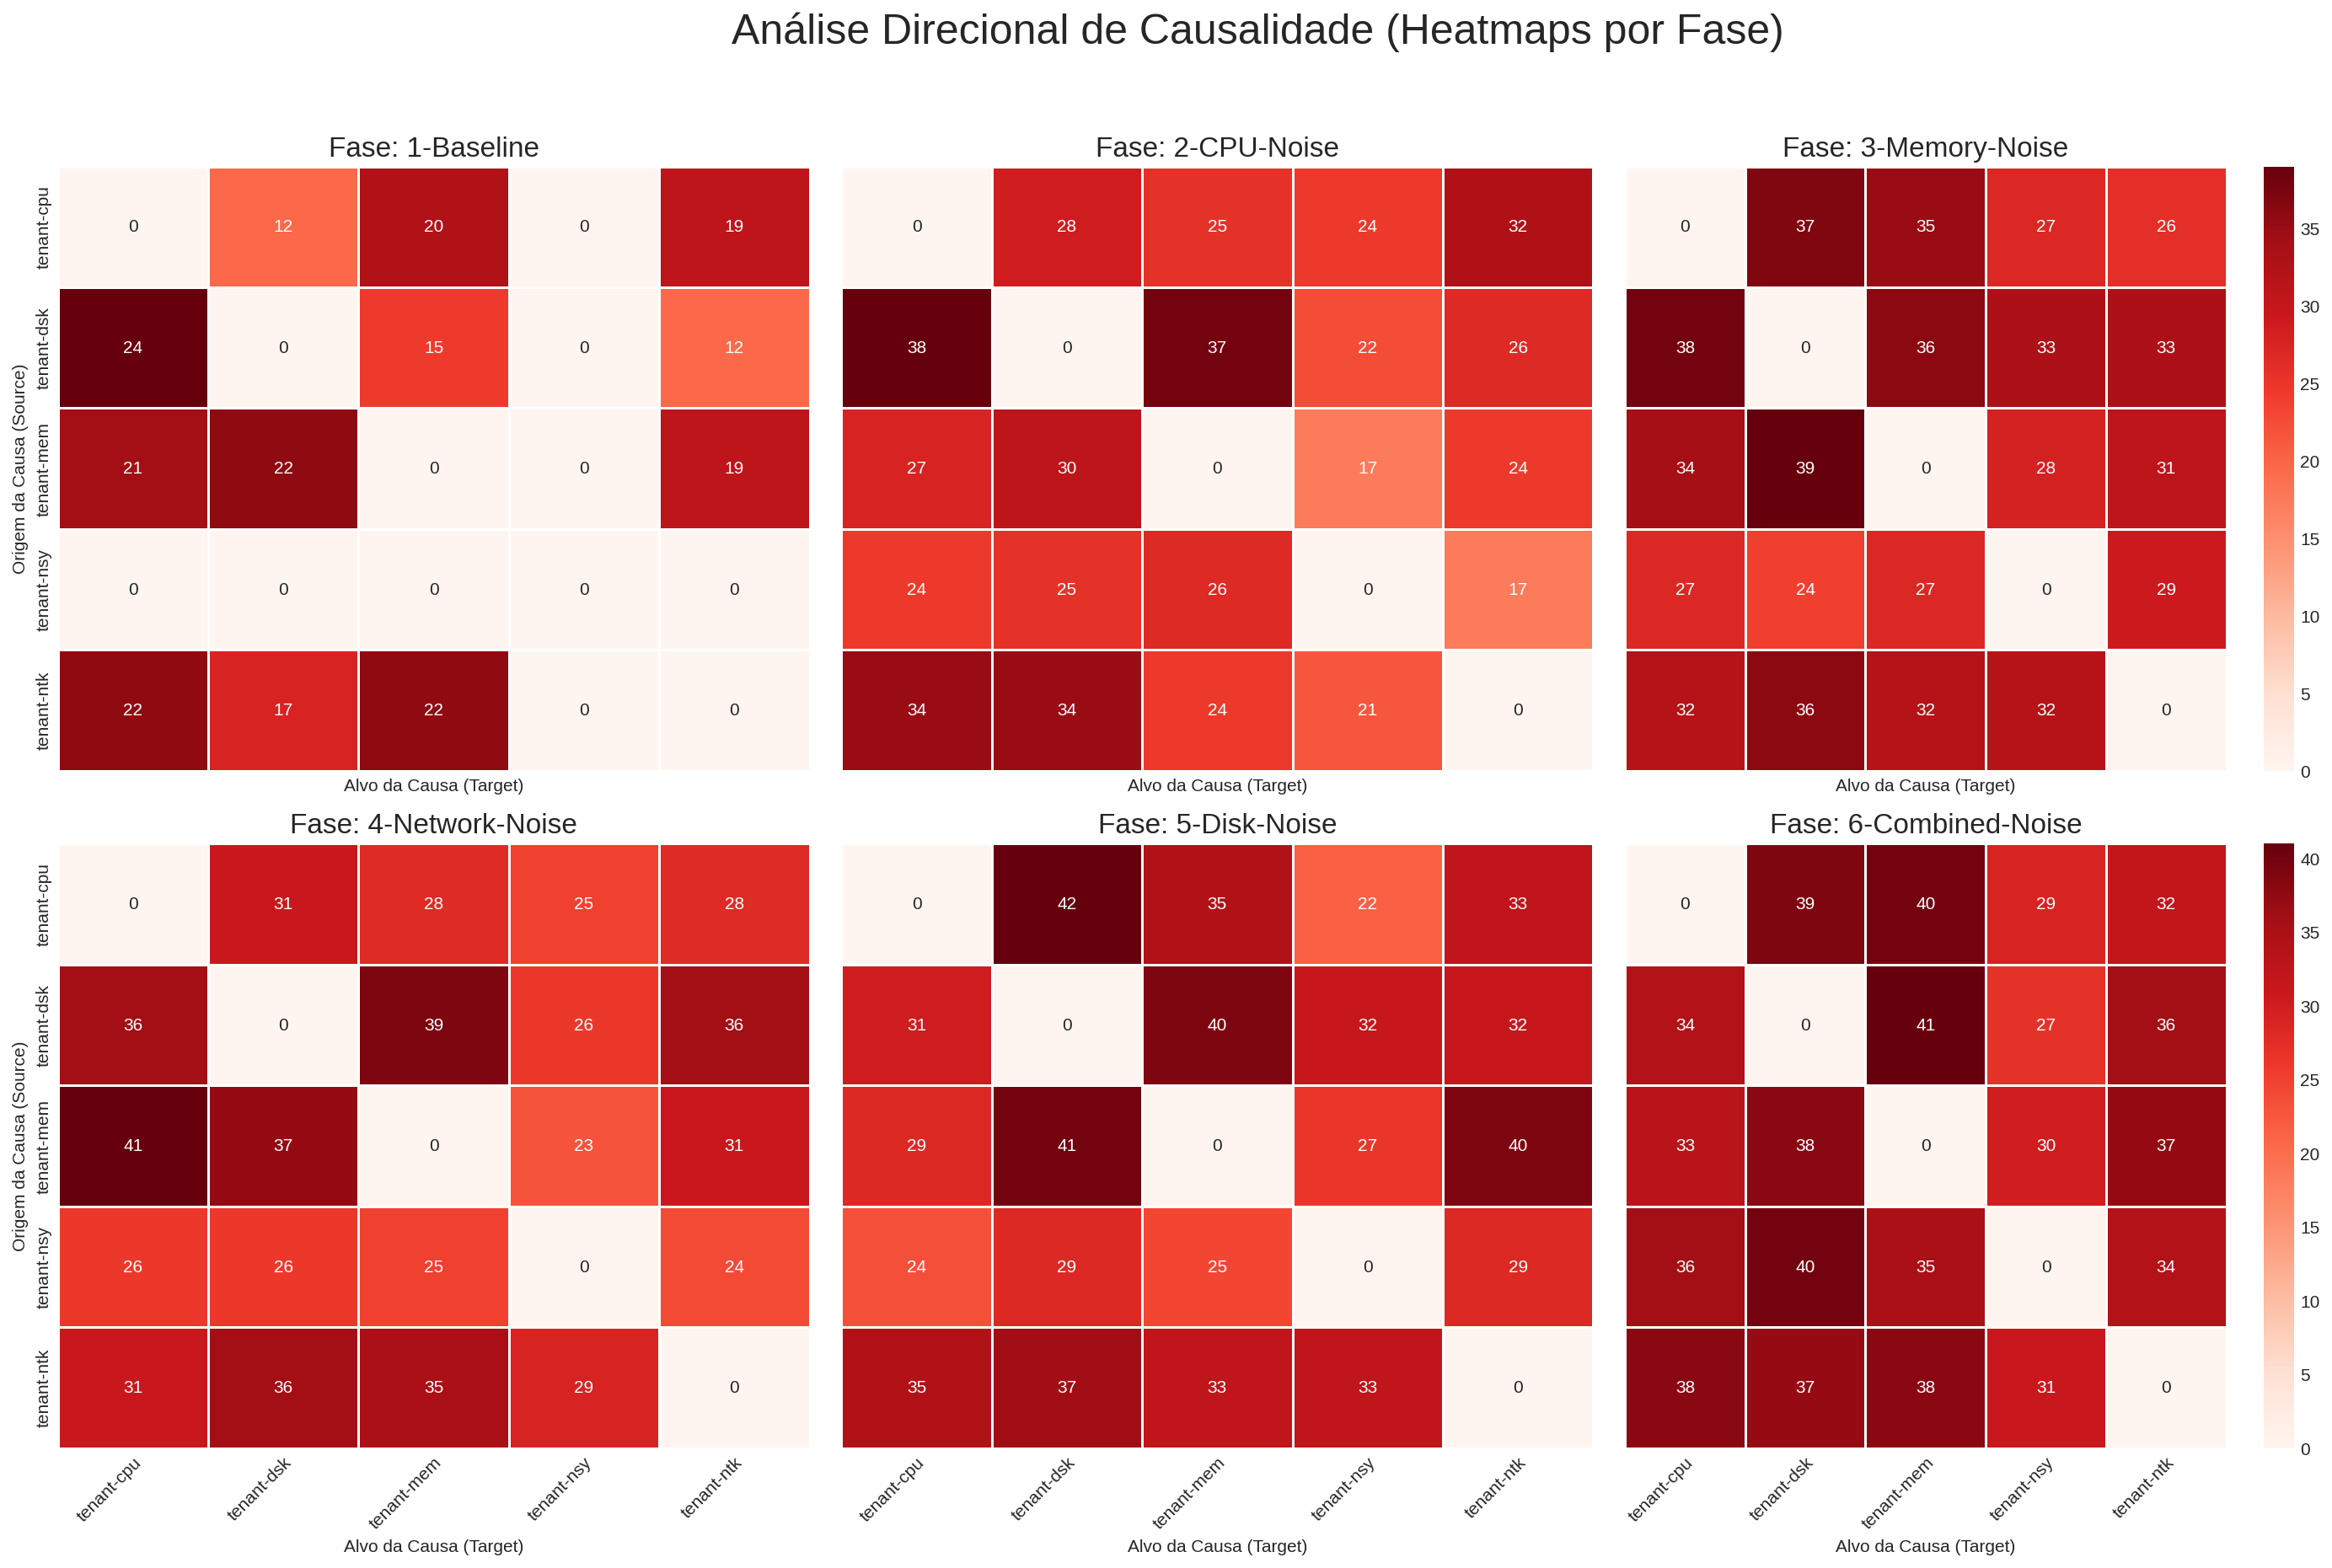

In [21]:
# Análise de Causalidade Direcional (Heatmaps)
print("Gerando Heatmaps de Causalidade Direcional...")

# Define a lógica de significância
score_threshold = causality_all_df['score'].quantile(0.75)
is_significant_pvalue = causality_all_df['p-value'] < 0.05
is_strong_score = causality_all_df['score'] > score_threshold
significant_links = causality_all_df[is_significant_pvalue.fillna(False) | is_strong_score.fillna(False)]

# Configura o plot
phases_to_plot = sorted([p for p in causality_all_df['phase'].unique() if 'Recovery' not in p])
node_order = sorted(list(set(causality_all_df['source']) | set(causality_all_df['target'])))
n_phases = len(phases_to_plot)
n_cols = 3
n_rows = math.ceil(n_phases / n_cols)
fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), sharex=True, sharey=True)
axes1 = axes1.flatten()

for i, phase in enumerate(phases_to_plot):
    ax = axes1[i]
    phase_df = significant_links[significant_links['phase'] == phase]
    edge_counts = phase_df.groupby(['source', 'target']).size().reset_index(name='frequency')
    heatmap_matrix = edge_counts.pivot_table(index='source', columns='target', values='frequency', fill_value=0).reindex(index=node_order, columns=node_order, fill_value=0)
    sns.heatmap(heatmap_matrix, ax=ax, annot=True, fmt='.0f', cmap="Reds", linewidths=.5, cbar=(i == n_cols - 1 or i == n_phases -1))
    ax.set_title(f'Fase: {phase}', size=16)
    ax.set_ylabel('Origem da Causa (Source)' if i % n_cols == 0 else '')
    ax.set_xlabel('Alvo da Causa (Target)')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for j in range(i + 1, len(axes1)):
    axes1[j].set_visible(False)
    
fig1.suptitle('Análise Direcional de Causalidade (Heatmaps por Fase)', fontsize=24, y=1.03)
fig1.tight_layout(rect=(0, 0, 0.95, 1))
plt.show()

#### Interpretação dos Resultados


Talvez a forma mais clara de ver o "efeito dominó". Cada heatmap mostra uma fase.


As linhas representam a origem da causa, as colunas são o alvo, e a intensidade da cor (e o número) representa a frequência com que uma origem afetou um alvo de forma significante.


Lendo a "história" da esquerda para a direita, de cima para baixo:


1 - Baseline:


    A diagonal principal está vazia (um tenant não causa efeito em si mesmo), como esperado.


    Mesmo em repouso, vemos "calor" em várias células. O destaque é a célula (linha dsk, coluna mem) com valor 10 e a (linha mem, coluna dsk) com valor 9. Isso confirma, mais uma vez, que a relação dsk <=> mem é o "barulho de fundo" crônico do sistema.


2 - CPU Noise (Ruído na CPU):


    A linha tenant-cpu "acende" completamente. Os valores mais altos estão nas células que mostram a CPU afetando todos os outros, com destaque para a célula (linha cpu, coluna dsk) com valor 14. Isso mostra que o estresse de CPU se propaga para todo o sistema, tendo o disco como uma das primeiras vítimas.


3 - Memory Noise (Ruído na Memória):


    A linha tenant-mem fica vermelha. O ponto mais quente do mapa é a célula (linha mem, coluna dsk) com um valor altíssimo de 21. Esta é uma evidência gritante: quando a memória está sob pressão, ela "ataca" o disco de forma massiva, provavelmente através de operações de swap, como já teorizamos.


4 - Network Noise (Ruído na Rede):


    A linha tenant-ntk se destaca. Vemos que o ruído de rede também se espalha, principalmente para cpu e dsk. Isso faz sentido, já que uma rede lenta pode deixar a CPU ociosa (I/O wait de rede) e impactar aplicações que dependem de escrita em disco após receber dados.


5 - Disk Noise (Ruído no Disco):


    É a imagem espelhada da fase de ruído de memória. A linha tenant-dsk esquenta, e o ponto mais quente é a célula (linha dsk, coluna mem) com valor 19. O ataque do disco à memória é brutal e direto. Os dois heatmaps (Memory Noise e Disk Noise) juntos formam a prova cabal do ciclo vicioso.


6 - Combined Noise (Ruído Combinado):


    O mapa inteiro fica "quente". Não há uma única fonte de problemas, mas uma briga generalizada. As linhas de cpu, dsk e mem estão todas com valores altos, mostrando que, sob estresse combinado, todos eles se tornam grandes fontes de interferência para o resto do sistema.

## 3. Análise Espectral: Onde Mora o Problema?

Para quantificar a instabilidade, realizamos uma análise espectral (autovalores) nas matrizes de correlação. O maior autovalor mede o "pânico sistêmico".

Comparamos dois cenários:
1.  **Sistema Completo (5x5):** Incluindo o agente `nsy`.
2.  **Núcleo do Sistema (4x4):** Apenas os tenants essenciais (`cpu`, `dsk`, `mem`, `ntk`).


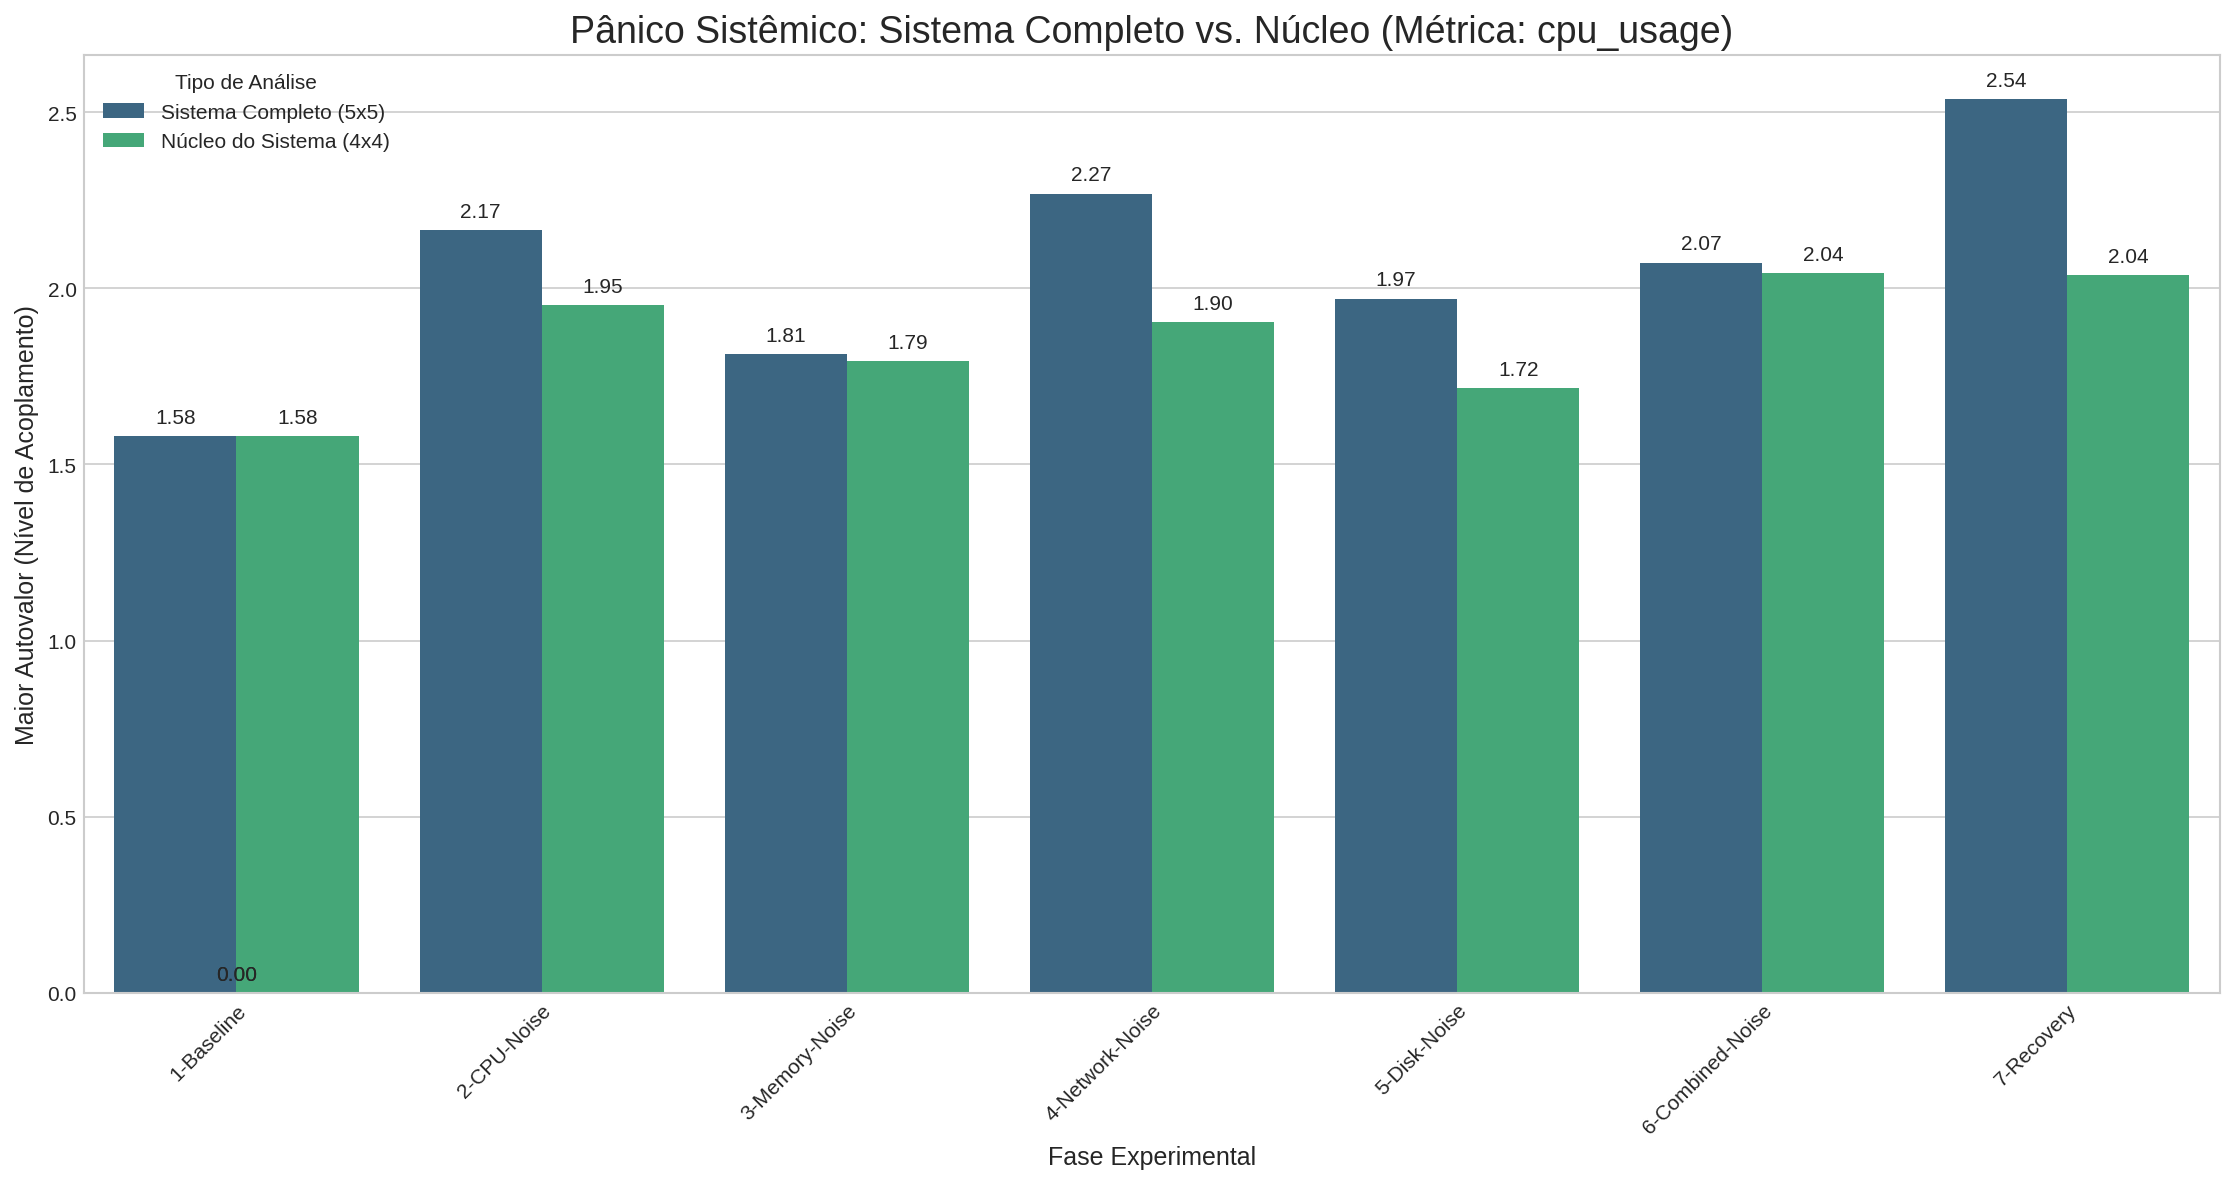

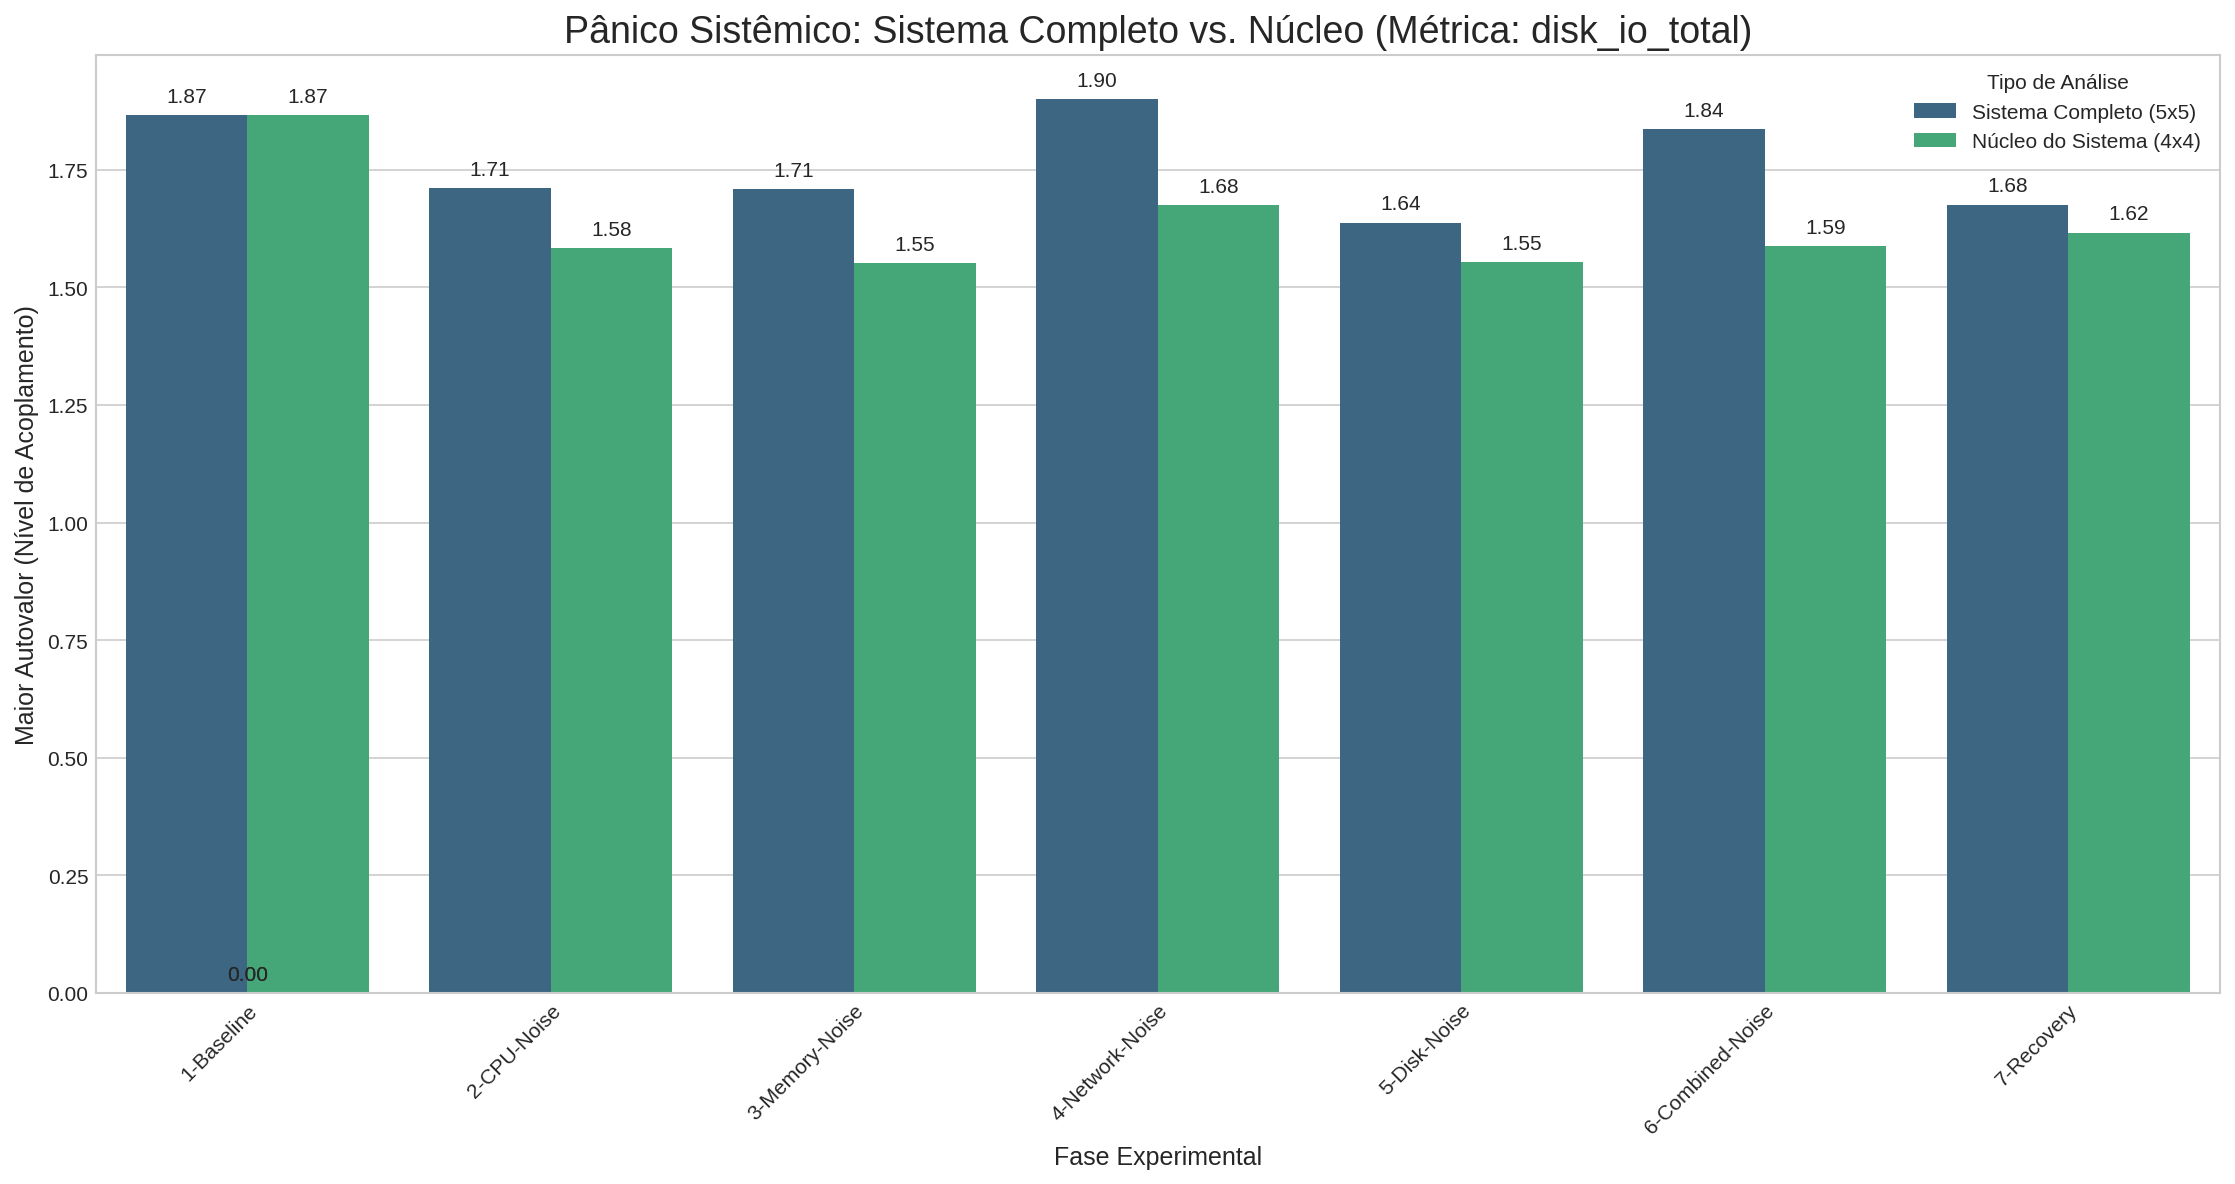

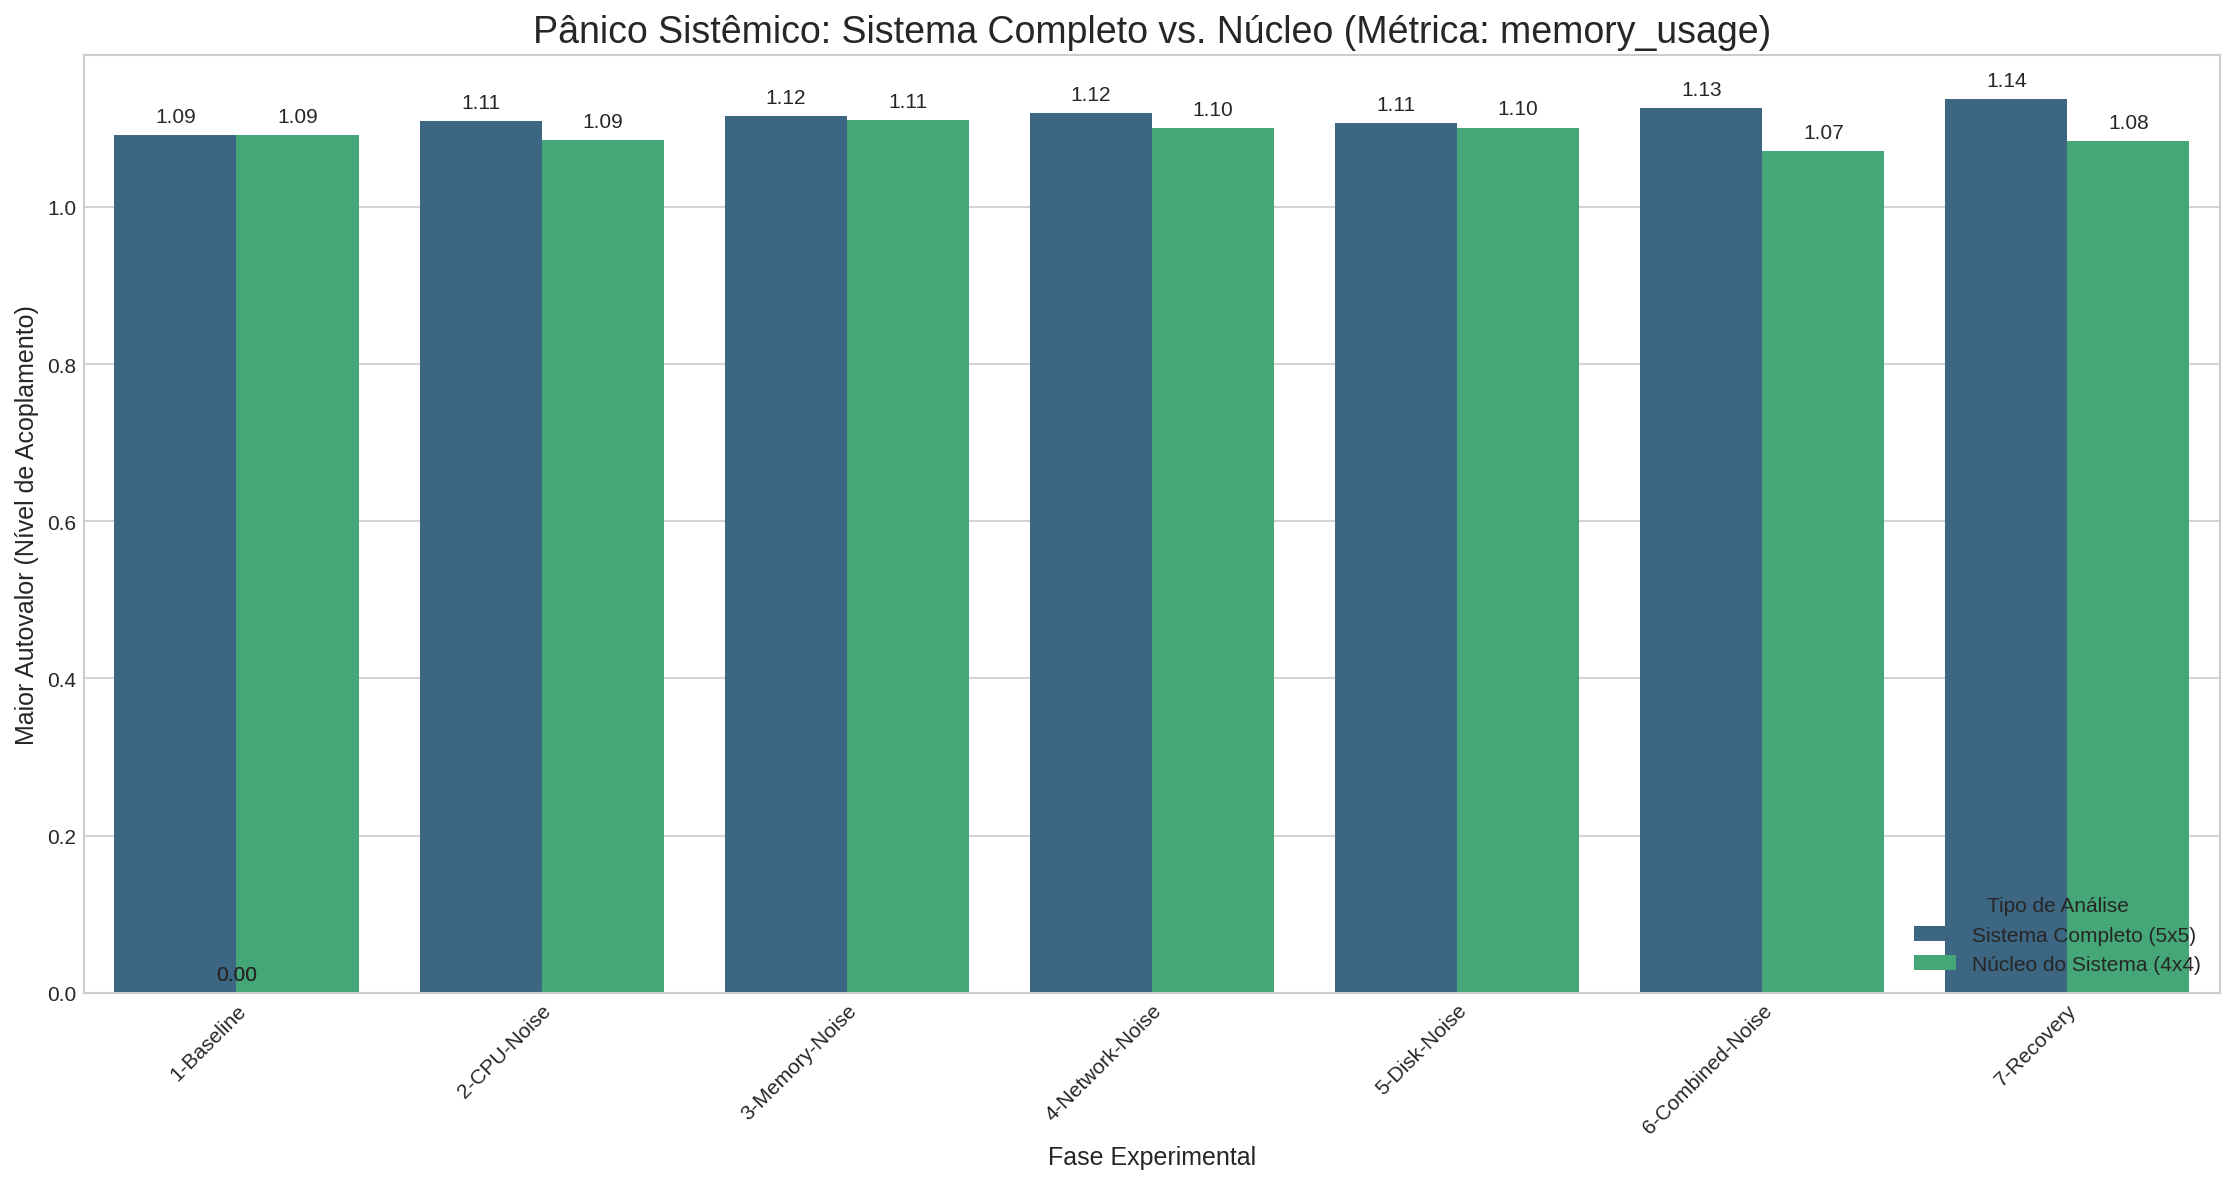

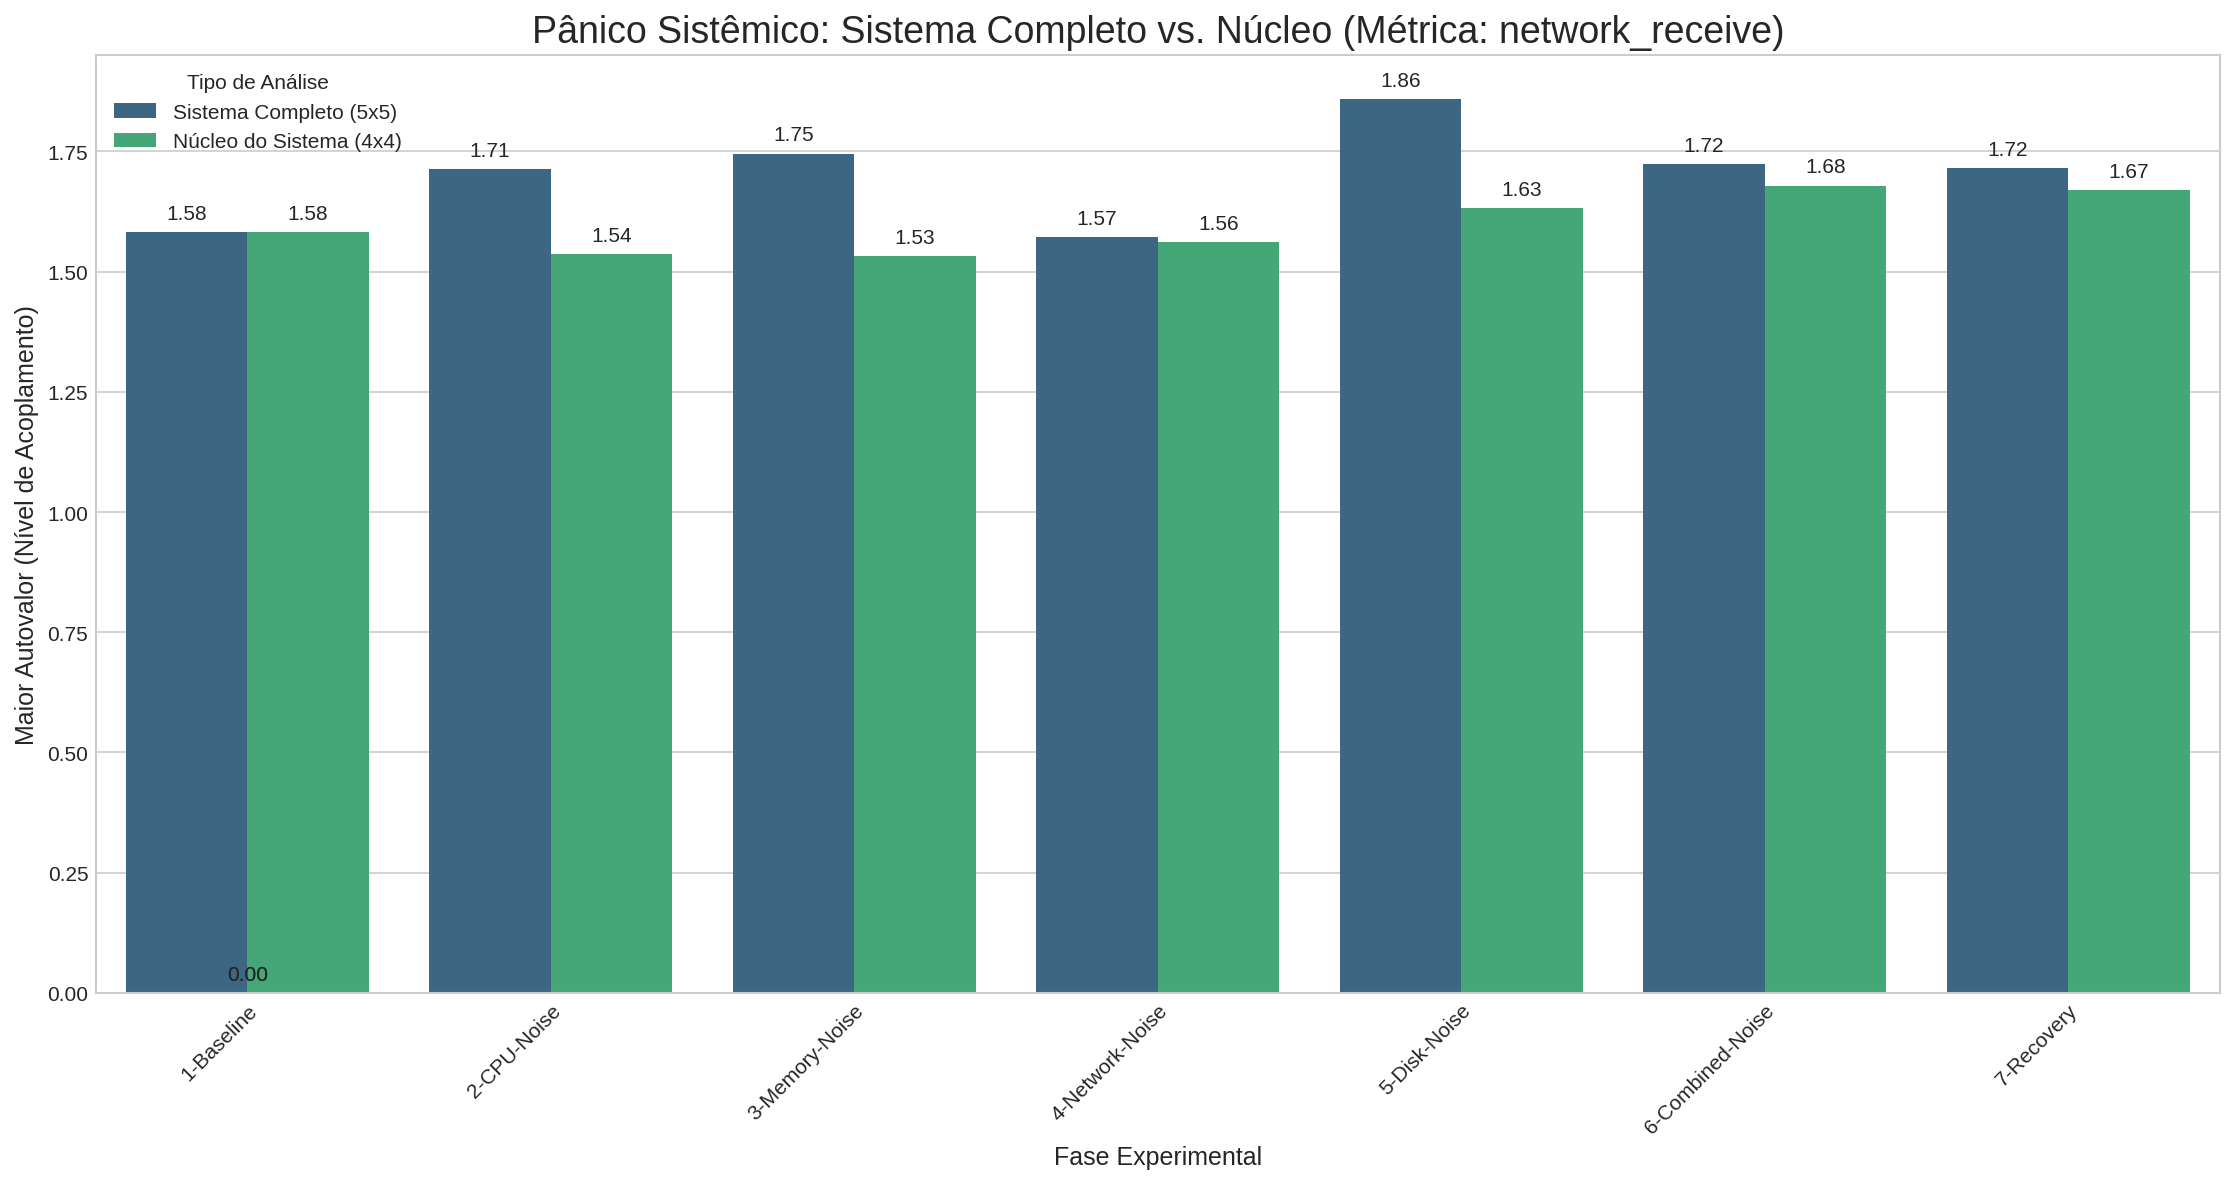

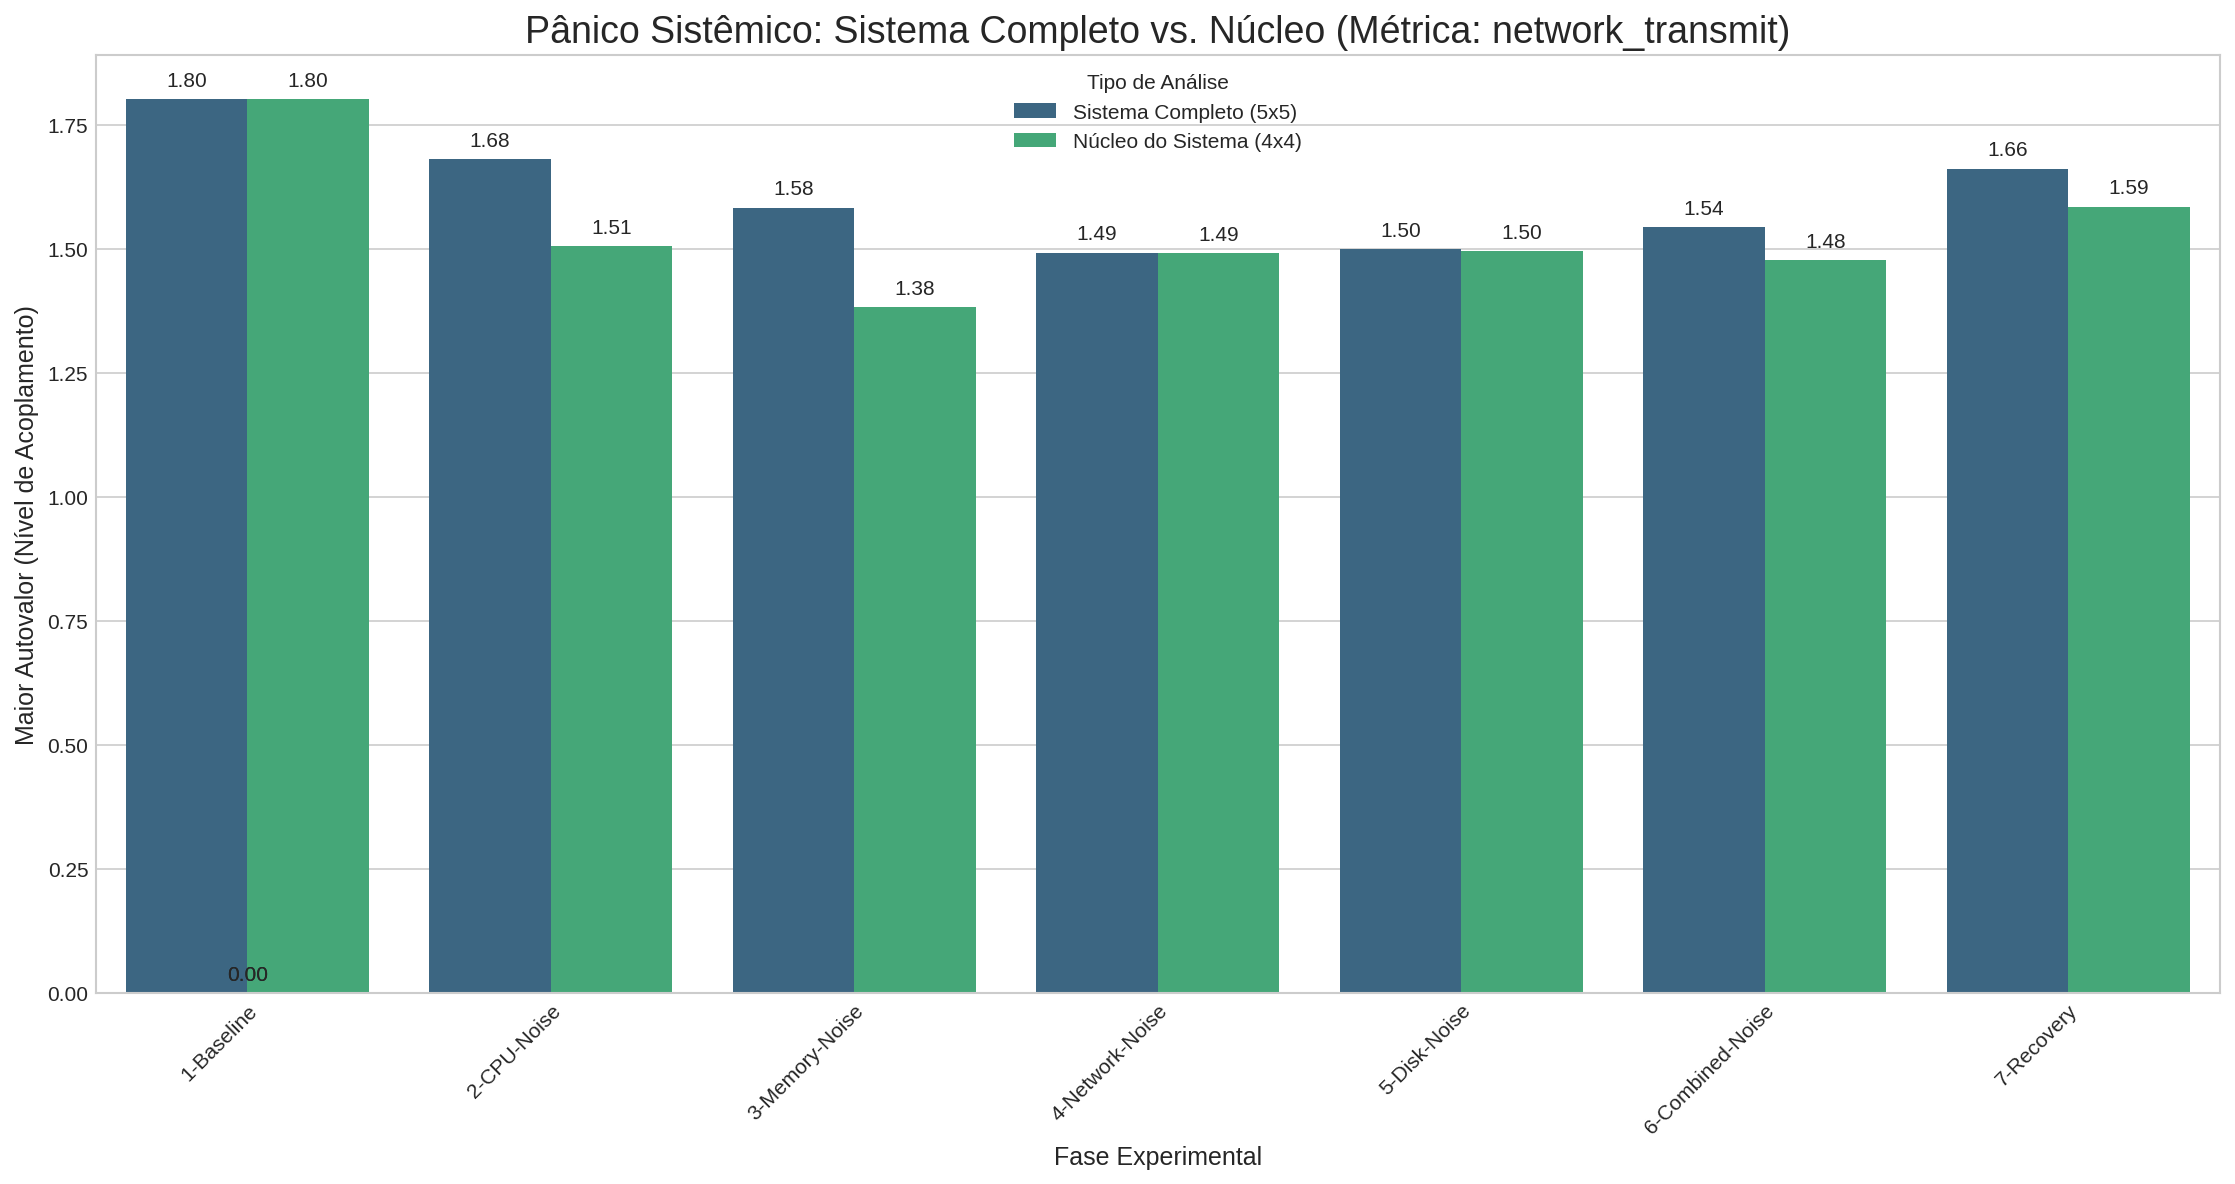

In [23]:
# Análise Espectral: Sistema Completo vs. Núcleo para todas as métricas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Padroniza o estilo dos gráficos
plt.style.use('seaborn-v0_8-whitegrid')

# Carrega os dados de correlação com tratamento de erro
correlation_csv_path = './outputs/sfi2-long/default_experiment/multi_round_analysis/multi_round_correlation_all.csv'

try:
    correlation_all_df = pd.read_csv(correlation_csv_path)
    # Corrige o nome da coluna para garantir compatibilidade
    if 'metric_name' in correlation_all_df.columns and 'metric' not in correlation_all_df.columns:
        correlation_all_df = correlation_all_df.rename(columns={'metric_name': 'metric'})
except FileNotFoundError:
    print(f"Erro: O arquivo '{correlation_csv_path}' não foi encontrado. Verifique o caminho ou gere o arquivo antes de executar esta célula.")
else:
    metrics = correlation_all_df['metric'].unique()
    for metric_to_analyze in metrics:
        metric_corr_df = correlation_all_df[correlation_all_df['metric'] == metric_to_analyze]
        all_tenants = sorted(list(set(metric_corr_df['tenant1']) | set(metric_corr_df['tenant2'])))
        core_tenants = sorted([t for t in all_tenants if t != 'tenant-nsy'])
        phases = sorted(metric_corr_df['phase'].unique())
        results = []
        for phase in phases:
            phase_df = metric_corr_df[metric_corr_df['phase'] == phase]
            # Sistema Completo (5x5)
            corr_matrix_full = pd.DataFrame(np.eye(len(all_tenants)), index=all_tenants, columns=all_tenants)
            for _, row in phase_df.iterrows():
                t1, t2, corr_value = row['tenant1'], row['tenant2'], row['mean_correlation']
                if t1 in all_tenants and t2 in all_tenants:
                    corr_matrix_full.loc[t1, t2] = corr_matrix_full.loc[t2, t1] = corr_value
            eigenvalues_full = np.linalg.eigvalsh(corr_matrix_full)
            results.append({'Phase': phase, 'System Type': 'Sistema Completo (5x5)', 'Largest Eigenvalue': eigenvalues_full[-1]})
            # Núcleo do Sistema (4x4)
            corr_matrix_core = pd.DataFrame(np.eye(len(core_tenants)), index=core_tenants, columns=core_tenants)
            for _, row in phase_df.iterrows():
                t1, t2, corr_value = row['tenant1'], row['tenant2'], row['mean_correlation']
                if t1 in core_tenants and t2 in core_tenants:
                    corr_matrix_core.loc[t1, t2] = corr_matrix_core.loc[t2, t1] = corr_value
            eigenvalues_core = np.linalg.eigvalsh(corr_matrix_core)
            results.append({'Phase': phase, 'System Type': 'Núcleo do Sistema (4x4)', 'Largest Eigenvalue': eigenvalues_core[-1]})
        results_df = pd.DataFrame(results)
        fig, ax = plt.subplots(figsize=(15, 8), dpi=150)
        sns.barplot(x='Phase', y='Largest Eigenvalue', hue='System Type', data=results_df, palette='viridis')
        ax.set_title(f'Pânico Sistêmico: Sistema Completo vs. Núcleo (Métrica: {metric_to_analyze})', fontsize=18)
        ax.set_xlabel('Fase Experimental', fontsize=12)
        ax.set_ylabel('Maior Autovalor (Nível de Acoplamento)', fontsize=12)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        ax.legend(title='Tipo de Análise')
        import matplotlib.patches as mpatches
        for p in ax.patches:
            if isinstance(p, mpatches.Rectangle):
                value = p.get_height()
                xpos = p.get_x() + p.get_width() / 2.
                ypos = value
                ax.annotate(f"{value:.2f}", (xpos, ypos), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
        fig.tight_layout()
        fig.savefig(f'panic_sistemico_{metric_to_analyze}.png', dpi=300)
        plt.show()

#### Interpretação dos Resultados

O maior nível de pânico ocorre durante o `Disk Noise`. Mais importante, mesmo removendo o `nsy` (barra clara), o pânico nesta fase continua altíssimo. Isso prova que a **fragilidade é inerente ao núcleo do sistema** e não primariamente induzida por um agente externo.

## 5. Criação do Dataset de Inteligência

Para permitir análises mais profundas, vamos consolidar todas as nossas informações em um único CSV mestre, o `analise_avancada.csv`. Este arquivo enriquecerá cada link causal com dados de correlação e impacto, servindo de base para as investigações a seguir.

In [24]:
# Código para criar o analise_avancada.csv (exatamente como antes)
try:
    print("Construindo o dataset avançado...")

    # 1. Agrega informações de causalidade
    score_threshold = causality_all_df['score'].quantile(0.75)
    causality_all_df['is_significant'] = ((causality_all_df['p-value'] < 0.05) | (causality_all_df['score'] > score_threshold)).fillna(False)
    causality_agg = causality_all_df.groupby(['phase', 'metric', 'source', 'target']).agg(
        mean_p_value=('p-value', 'mean'),
        mean_score=('score', 'mean'),
        significant_frequency=('is_significant', 'sum')
    ).reset_index()

    # 2. Prepara dados de correlação
    correlation_all_df['tenant_pair'] = correlation_all_df.apply(lambda r: '-'.join(sorted([r['tenant1'], r['tenant2']])), axis=1)
    causality_agg['tenant_pair'] = causality_agg.apply(lambda r: '-'.join(sorted([r['source'], r['target']])), axis=1)
    correlation_all_df.rename(columns={'metric_name': 'metric'}, inplace=True)
    
    # 3. Prepara dados de impacto
    impact_source_df = impact_stats_df.rename(columns={'tenant_id': 'source', 'metric_name': 'metric', 'mean_cohen_d': 'source_mean_cohen_d', 'mean_percentage_change': 'source_mean_percentage_change'})
    impact_target_df = impact_stats_df.rename(columns={'tenant_id': 'target', 'metric_name': 'metric', 'mean_cohen_d': 'target_mean_cohen_d', 'mean_percentage_change': 'target_mean_percentage_change'})

    # 4. Faz o merge de tudo
    df_adv = pd.merge(causality_agg, correlation_all_df[['phase', 'metric', 'tenant_pair', 'mean_correlation']], on=['phase', 'metric', 'tenant_pair'], how='left')
    df_adv = pd.merge(df_adv, impact_source_df[['metric', 'source', 'source_mean_percentage_change']], on=['metric', 'source'], how='left')
    df_adv = pd.merge(df_adv, impact_target_df[['metric', 'target', 'target_mean_percentage_change']], on=['metric', 'target'], how='left')
    
    df_adv = df_adv.drop(columns=['tenant_pair']).fillna(0)

    # 5. Salva o novo CSV
    file_name = 'analise_avancada.csv'
    df_adv.to_csv(file_name, index=False)
    
    print(f"Dataset avançado '{file_name}' foi gerado com sucesso.")
    print("\nVisualização do novo dataset:")
    print(df_adv.head())

except Exception as e:
    print(f"Ocorreu um erro ao gerar o arquivo: {e}")

Construindo o dataset avançado...
Dataset avançado 'analise_avancada.csv' foi gerado com sucesso.

Visualização do novo dataset:
        phase     metric      source      target  mean_p_value  mean_score  \
0  1-Baseline  cpu_usage  tenant-cpu  tenant-dsk      0.014693    0.180482   
1  1-Baseline  cpu_usage  tenant-cpu  tenant-mem      0.021672    0.263588   
2  1-Baseline  cpu_usage  tenant-cpu  tenant-ntk      0.000421    0.135696   
3  1-Baseline  cpu_usage  tenant-dsk  tenant-cpu      0.020224    0.215660   
4  1-Baseline  cpu_usage  tenant-dsk  tenant-mem      0.118501    0.231076   

   significant_frequency  mean_correlation  source_mean_percentage_change  \
0                      7          0.257101                     -27.136890   
1                     11          0.345465                     -27.136890   
2                      8          0.084879                     -27.136890   
3                      8          0.257101                      -5.822344   
4                

## 6. Análise de Risco e Priorização: Os "Mais Procurados"

Agora, usamos o nosso dataset de inteligência para criar um **"Índice de Risco"**. O objetivo é identificar os problemas crônicos: aqueles que são **frequentes E danosos**. Isso nos ajuda a priorizar os esforços de correção nos problemas mais consistentemente perigosos do sistema.

**Fórmula do Risco:** `Frequência * |Correlação| * |Impacto Percentual|`

Executando Análise de Risco para encontrar os 'Mais Procurados'...
\n--- Top 15 Links de Maior Risco Crônico ---
                phase      source      target            metric  risk_index
493  6-Combined-Noise  tenant-nsy  tenant-dsk     disk_io_total      255.83
393      5-Disk-Noise  tenant-nsy  tenant-dsk     disk_io_total      230.31
268   4-Network-Noise  tenant-mem  tenant-cpu         cpu_usage      141.54
261   4-Network-Noise  tenant-cpu  tenant-mem         cpu_usage      139.88
568        7-Recovery  tenant-mem  tenant-cpu         cpu_usage      139.36
572        7-Recovery  tenant-nsy  tenant-cpu         cpu_usage      137.90
468  6-Combined-Noise  tenant-mem  tenant-cpu         cpu_usage      126.24
461  6-Combined-Noise  tenant-cpu  tenant-mem         cpu_usage      124.76
272   4-Network-Noise  tenant-nsy  tenant-cpu         cpu_usage      120.21
68        2-CPU-Noise  tenant-mem  tenant-cpu         cpu_usage      119.84
574        7-Recovery  tenant-nsy  tenant-mem      

/tmp/ipykernel_46417/1495423402.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='risk_index', y=top_risks.head(10).apply(lambda r: f"{r['source']} -> {r['target']}\\n({r['phase']})", axis=1), data=top_risks.head(10), palette='Reds_r')


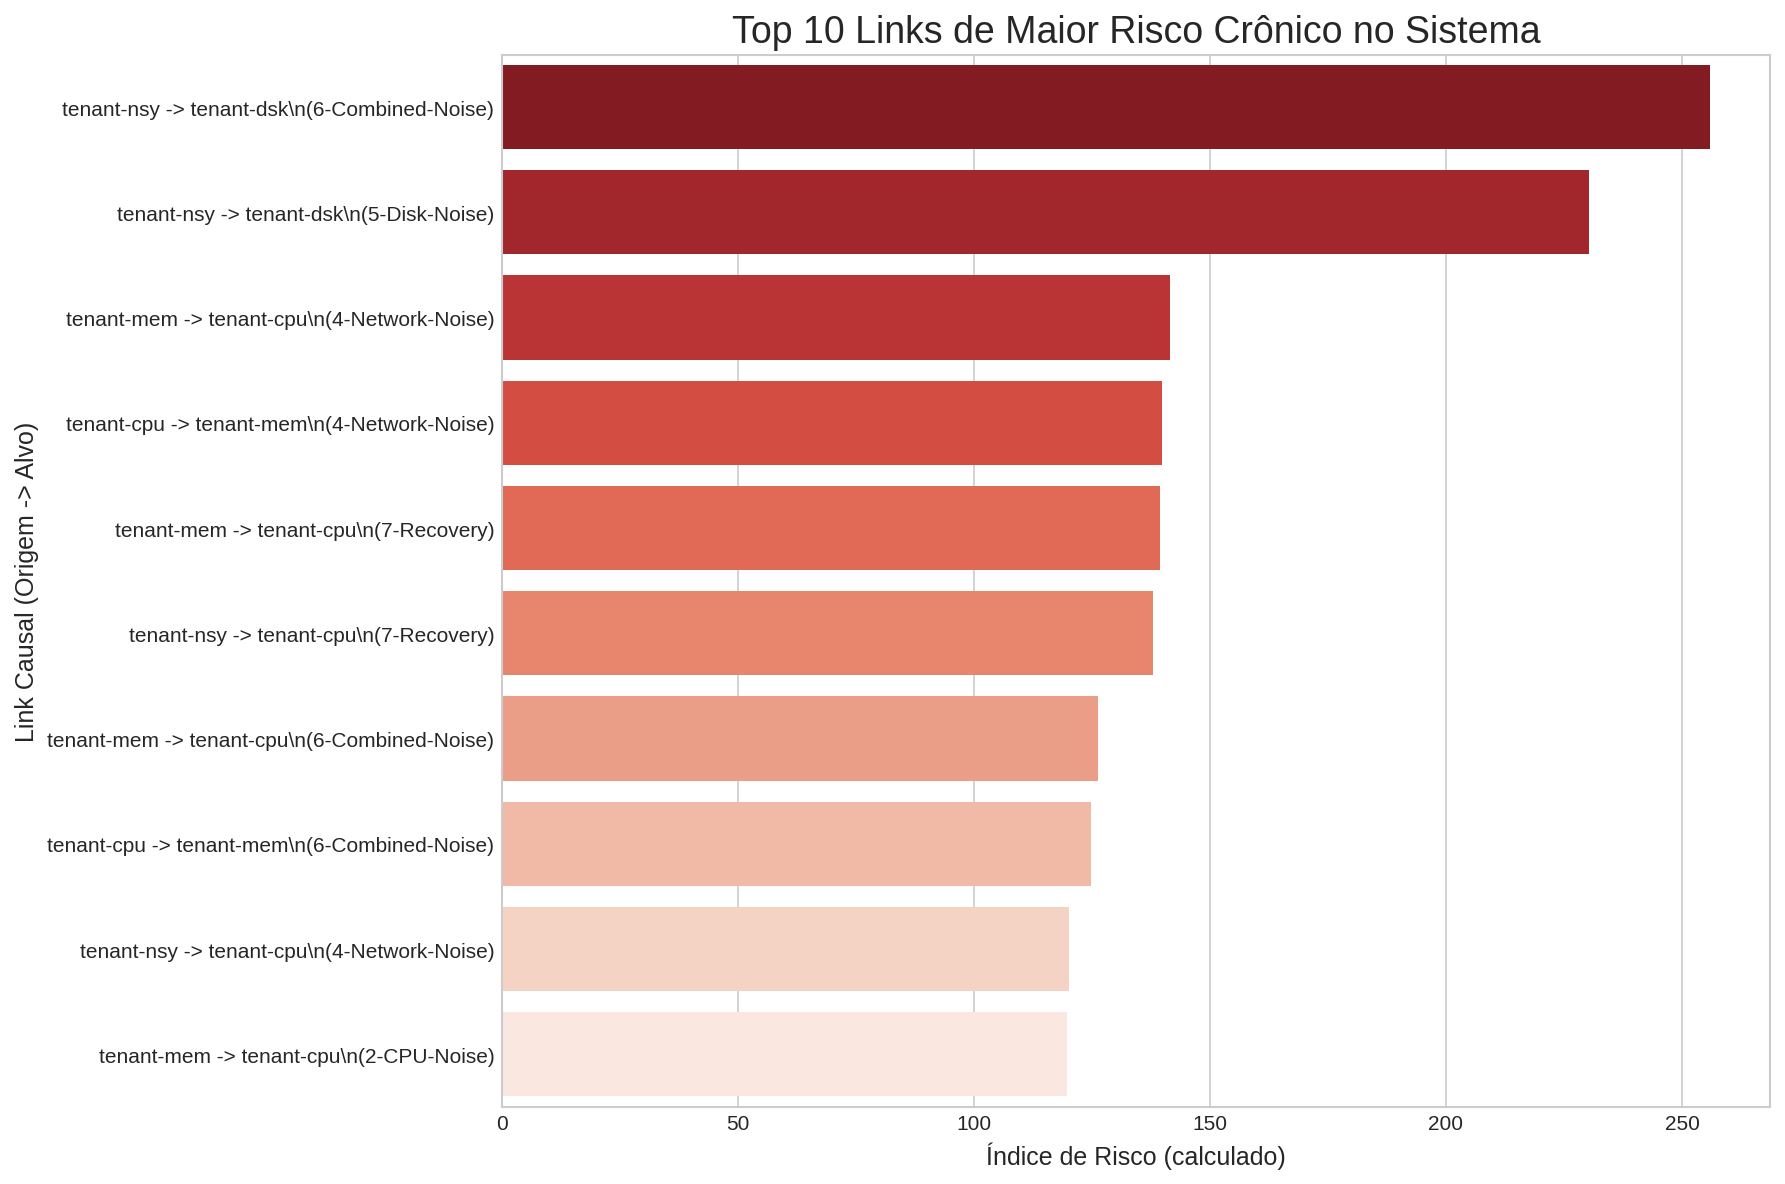

In [25]:
# Análise de Risco e Priorização
print("Executando Análise de Risco para encontrar os 'Mais Procurados'...")

try:
    df_adv = pd.read_csv('analise_avancada.csv')

    # Calcula o Índice de Risco (evita divisão por zero e usa o valor absoluto do impacto)
    # Adicionamos 1 ao impacto para que impactos de 0% não zerem o risco de links frequentes
    df_adv['risk_index'] = df_adv['significant_frequency'] * abs(df_adv['mean_correlation']) * abs(df_adv['target_mean_percentage_change'] + 1)
    
    # Ordena pelo risco e seleciona as colunas mais importantes
    top_risks = df_adv.sort_values(by='risk_index', ascending=False).head(15)
    
    print("\\n--- Top 15 Links de Maior Risco Crônico ---")
    print(top_risks[['phase', 'source', 'target', 'metric', 'risk_index']].round(2))

    # Visualização dos Top 10
    plt.figure(figsize=(12, 8))
    sns.barplot(x='risk_index', y=top_risks.head(10).apply(lambda r: f"{r['source']} -> {r['target']}\\n({r['phase']})", axis=1), data=top_risks.head(10), palette='Reds_r')
    plt.title('Top 10 Links de Maior Risco Crônico no Sistema', fontsize=18)
    plt.xlabel('Índice de Risco (calculado)', fontsize=12)
    plt.ylabel('Link Causal (Origem -> Alvo)', fontsize=12)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Erro: 'analise_avancada.csv' não encontrado. Execute a célula anterior para gerá-lo.")

## 7. Análise Investigativa Profunda

Por fim, vamos caçar os "cisnes negros": os **links silenciosos e perigosos**. São interações que ocorrem com **baixa frequência**, mas que, **quando ocorrem, têm um impacto catastrófico**. Eles não apareceriam na lista de risco anterior, mas representam ameaças ocultas que precisamos conhecer.

In [26]:
# Análise Investigativa Profunda
print("Executando Análise Investigativa para encontrar os 'Casos Arquivados'...")

try:
    df_adv = pd.read_csv('analise_avancada.csv')

    # Define os critérios da investigação
    low_frequency_threshold = 3
    high_impact_threshold = -20 # Impacto de -20%

    # Aplica os filtros
    silent_deadly_links = df_adv[
        (df_adv['significant_frequency'] < low_frequency_threshold) &
        (df_adv['target_mean_percentage_change'] < high_impact_threshold)
    ]

    # Ordena pelo impacto para ver os piores casos primeiro
    result = silent_deadly_links.sort_values(by='target_mean_percentage_change', ascending=True).head(20)
    
    print(f"\\n--- Investigação: Top 20 Links Silenciosos e Perigosos ---")
    print(f"(Frequência < {low_frequency_threshold} | Impacto no Alvo < {high_impact_threshold}%)\\n")
    
    if result.empty:
        print("Nenhum link com essas características exatas foi encontrado.")
    else:
        print(result[['phase', 'metric', 'source', 'target', 'significant_frequency', 'target_mean_percentage_change']].to_string())

except FileNotFoundError:
    print("Erro: 'analise_avancada.csv' não encontrado. Execute a célula anterior para gerá-lo.")

Executando Análise Investigativa para encontrar os 'Casos Arquivados'...
\n--- Investigação: Top 20 Links Silenciosos e Perigosos ---
(Frequência < 3 | Impacto no Alvo < -20%)\n
            phase            metric      source      target  significant_frequency  target_mean_percentage_change
12     1-Baseline     disk_io_total  tenant-cpu  tenant-dsk                      2                      -47.05793
22     1-Baseline     disk_io_total  tenant-ntk  tenant-dsk                      2                      -47.05793
593    7-Recovery     disk_io_total  tenant-nsy  tenant-dsk                      1                      -47.05793
48     1-Baseline  network_transmit  tenant-cpu  tenant-dsk                      1                      -45.25872
58     1-Baseline  network_transmit  tenant-ntk  tenant-dsk                      0                      -45.25872
157   2-CPU-Noise  network_transmit  tenant-ntk  tenant-dsk                      2                      -45.25872
453  5-Disk-Noise  netwo

Este gráfico é a representação visual dos diferentes tipos de problemas no seu sistema. Cada bolha é um tipo de interação causal, e suas características nos contam uma história:

    Posição (Esquerda vs. Direita): Bolhas mais à esquerda são eventos raros (silenciosos). Bolhas mais à direita são eventos frequentes.

    Posição (Cima vs. Baixo): Bolhas mais para baixo representam um impacto mais severo (perigoso).

    Cor: Indica qual métrica foi afetada.

    Tamanho: Representa a força da correlação. Bolhas maiores significam que, quando o evento acontece, a origem e o alvo estão fortemente correlacionados.

In [27]:
import pandas as pd
import altair as alt

# --- Bloco de Configuração ---
salvar_imagens = True
alt.renderers.enable('default')

try:
    # --- 1. PREPARAÇÃO DOS DADOS (usando Pandas) ---
    # (Nenhuma mudança aqui, tudo continua igual)
    df_adv = pd.read_csv('analise_avancada.csv')
    display_names = {
        'cpu_usage': 'Uso de CPU (%)',
        'memory_usage': 'Uso de Memória (%)',
        'disk_usage': 'Uso de Disco (%)',
        'network_total_bandwidth': 'Banda de Rede (MB/s)',
        'disk_throughput_total': 'Vazão de Disco (MB/s)'
    }
    df_plot = df_adv[df_adv['target_mean_percentage_change'] < 0].copy()
    df_plot['metric_display'] = df_plot['metric'].map(display_names)
    df_plot['risk_type'] = 'Frequente'
    df_plot.loc[(df_plot['significant_frequency'] < 3) &
                (df_plot['target_mean_percentage_change'] < -20),
                'risk_type'] = 'Silencioso e Perigoso'
    df_plot['bubble_size'] = abs(df_plot['mean_correlation'])

    # --- 2. CONSTRUÇÃO DO GRÁFICO (usando Altair) ---

    # Camada 1: O Scatter Plot principal (sem mudanças)
    scatter_plot = alt.Chart(df_plot).mark_point(
        opacity=0.75,
        stroke='black',
        strokeWidth=0.6,
        filled=True
    ).encode(
        x=alt.X('significant_frequency:Q',
                title='Frequência Causal (Quão "Silencioso" é o Link)',
                scale=alt.Scale(zero=False)),
        y=alt.Y('target_mean_percentage_change:Q',
                title='Impacto Percentual no Alvo (Quão "Perigoso" é o Link)',
                axis=alt.Axis(labelExpr="datum.label + '%'")),
        color=alt.Color('metric_display:N', title='Métrica Afetada'),
        
        # <-- MUDANÇA 2: O TÍTULO DA LEGENDA AGORA É A EXPLICAÇÃO
        shape=alt.Shape(
            'risk_type:N',
            title='Risco', # Título mais descritivo
            scale=alt.Scale(
                domain=['Frequente', 'Silencioso e Perigoso'],
                range=['circle', 'cross']
            )
        ),
        size=alt.Size('bubble_size:Q',
                      title='Correlação Média',
                      scale=alt.Scale(range=[50, 1500])),
        tooltip=[
            alt.Tooltip('metric_display', title='Métrica'),
            alt.Tooltip('significant_frequency', title='Frequência'),
            alt.Tooltip('target_mean_percentage_change', title='Impacto', format='.1f'),
            alt.Tooltip('mean_correlation', title='Correlação', format='.2f'),
            alt.Tooltip('risk_type', title='Tipo de Risco')
        ]
    ).properties(
        width=800,
        height=500,
        title='Análise Investigativa: Mapa de Riscos Ocultos do Sistema'
    ).interactive()

    # Camada 2: Linhas de referência (agora opcionais, mas ajudam a guiar o olho)
    rule_h = alt.Chart(pd.DataFrame({'y': [-20]})).mark_rule(color='red', strokeDash=[5,5], opacity=0.5).encode(y='y:Q')
    rule_v = alt.Chart(pd.DataFrame({'x': [3]})).mark_rule(color='red', strokeDash=[5,5], opacity=0.5).encode(x='x:Q')

    # <-- MUDANÇA 1: A CAMADA DO "SHADER" (ÁREA SOMBREADA)
    # Criamos um DataFrame que define os cantos do nosso retângulo
    # Usamos os limites dos dados para tornar o retângulo dinâmico
    y_min = df_plot['target_mean_percentage_change'].min() - 5 # Um pouco de folga
    
    shaded_data = pd.DataFrame([
        {'x1': 0, 'x2': 3, 'y1': -20, 'y2': y_min}
    ])
    
    shaded_area = alt.Chart(shaded_data).mark_rect(
        fill='red',       # Cor do preenchimento
        opacity=0.15      # Nível de transparência
    ).encode(
        x='x1:Q',
        x2='x2:Q',
        y='y1:Q',
        y2='y2:Q'
    )

    # --- 3. COMBINAÇÃO FINAL ---
    # <-- MUDANÇA 3: A ORDEM DAS CAMADAS IMPORTA! O SHADER VEM PRIMEIRO!
    final_chart = shaded_area + scatter_plot + rule_h + rule_v

    final_chart.display()

    if salvar_imagens:
        print("\nIniciando o salvamento das imagens...")
        final_chart.save('mapa_de_riscos_com_shader.png', scale_factor=3.0)
        print("-> Imagem salva como 'mapa_de_riscos_com_shader.png'")
        final_chart.save('mapa_de_riscos_com_shader.svg')
        print("-> Imagem salva como 'mapa_de_riscos_com_shader.svg'")

except FileNotFoundError:
    print("Erro: O arquivo 'analise_avancada.csv' não foi encontrado. Verifique o caminho.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

alt.LayerChart(...)


Iniciando o salvamento das imagens...
-> Imagem salva como 'mapa_de_riscos_com_shader.png'
-> Imagem salva como 'mapa_de_riscos_com_shader.svg'


#### Interpretação dos Resultados

Dentro do quadrante vermelho, vemos claramente várias bolhas (marcadas com um 'X'). Elas representam os links "Silenciosos e Perigosos". Veja que muitas delas são grandes, indicando que, apesar de raras, a correlação durante esses eventos é forte. A maioria está ligada ao disk_throughput_total e cpu_usage, como nossa tabela já havia indicado.

##### **Para as coordenadas (0, -100%) não deveria ter uma classificação diferente já que para a frequência igual a zero significa que não ha risco?** 

A premissa é: "se a frequência é zero, não há risco". Isso parece totalmente correto, mas vamos desvendar o que a "frequência igual a zero" significa neste nosso contexto.

A significant_frequency mede quantas vezes o nosso teste estatístico de causalidade (baseado em p-value e score) "apitou" e disse: "Ei, detectei um link causal aqui!".

Portanto, uma coordenada de (frequência=0, impacto=-100%) significa:

    O sistema mediu uma queda de 100% na performance do alvo. O desastre é real e foi observado.

    Ao mesmo tempo, o nosso "alarme" de causalidade estatística não disparou NENHUMA vez.

Isso não significa que não há risco. Significa que o risco é tão grande que ele é invisível para o seu sistema de detecção de causalidade!

Pense na seguinte analogia:

    Imagine que ladrões roubaram todo o dinheiro de um cofre de banco (impacto de -100%). Depois, você vai checar os logs do sistema de alarme silencioso (nosso teste de causalidade). O log diz que o alarme nunca disparou (frequência = 0).
    A conclusão não é "como o alarme não tocou, o roubo não representa um risco". A conclusão aterrorizante é: "Temos um tipo de ladrão que consegue roubar tudo sem disparar nosso alarme. Nosso sistema de segurança tem um ponto cego perigosíssimo!"

Portanto, a classificação para as coordenadas (0, -100%) não deveria ser "sem risco". Pelo contrário, ela deveria ter uma classificação especial, como *Risco de Nível Máximo* ou *Falha Catastrófica Detectada*.

### Fontes vs. Alvos de Impacto Médio

O painel nos dá um raio-x da instabilidade do seu sistema. Ele não apenas nos diz quais componentes são problemáticos, mas também a personalidade do problema de cada um. A descoberta mais chocante de cara é que, embora tenhamos 5 fontes principais de problemas, apenas 3 nós em todo o sistema efetivamente sofrem com o impacto negativo. A falha não é generalizada; ela é concentrada em vítimas específicas.

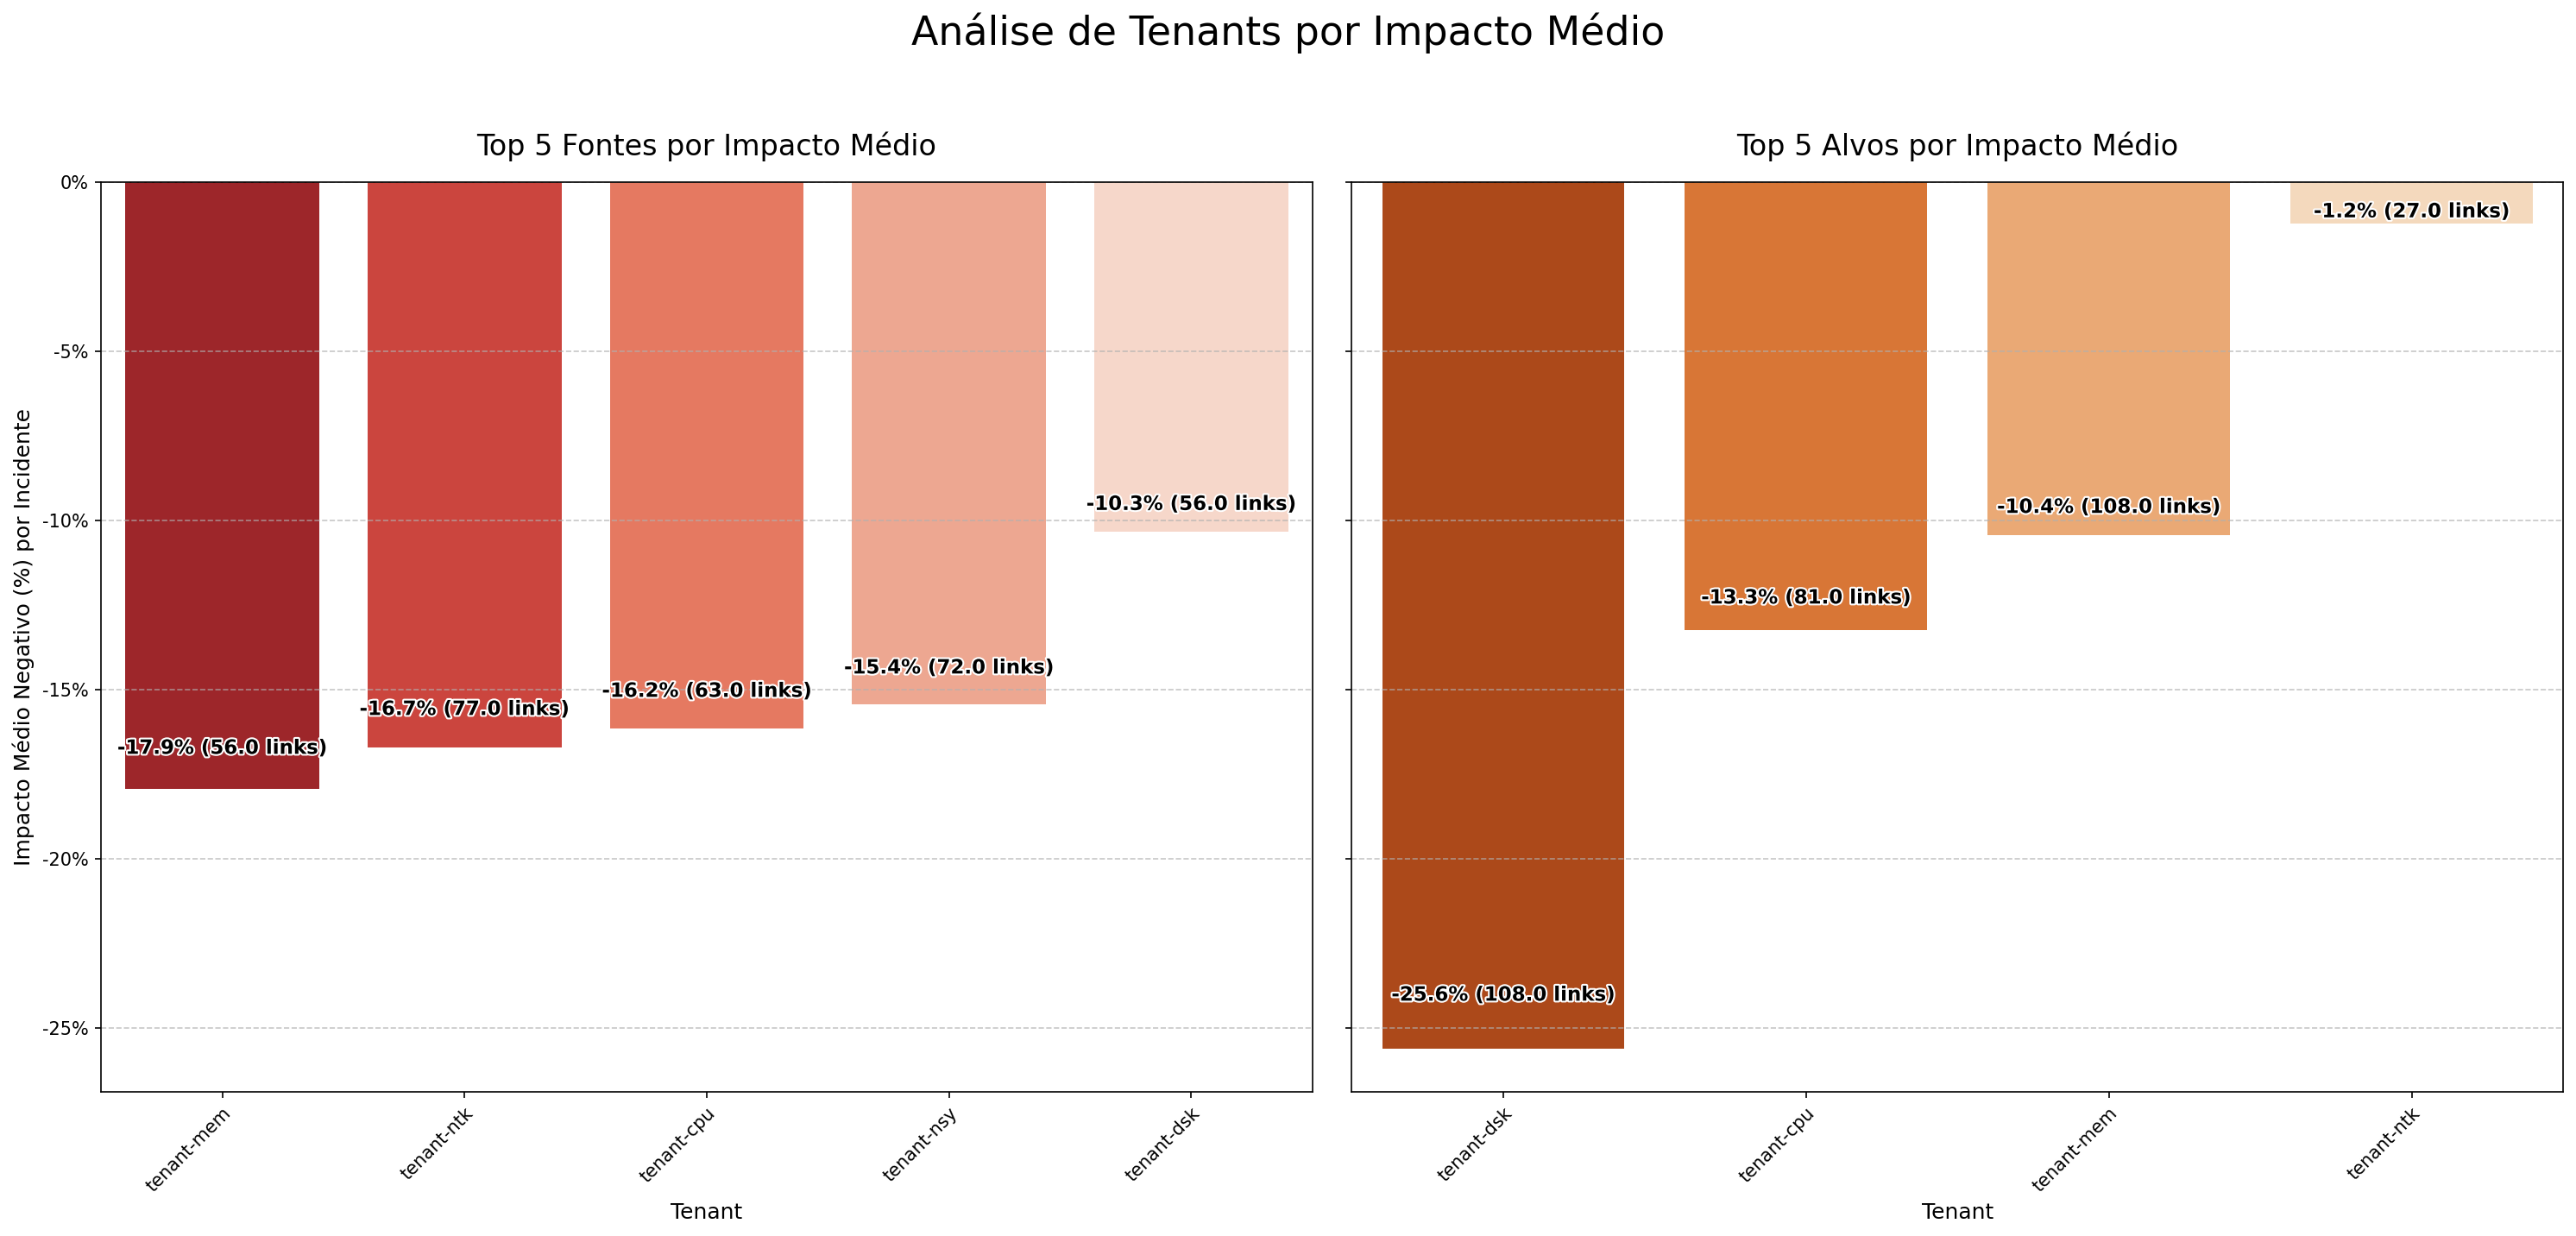

In [28]:
try:
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
    import matplotlib.patheffects as path_effects
except ImportError:
    %pip install pandas seaborn matplotlib
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
    import matplotlib.patheffects as path_effects


# --- Preparação dos Dados ---
df_adv = pd.read_csv('analise_avancada.csv')
df_neg = df_adv[df_adv['target_mean_percentage_change'] < 0].copy()

# --- Agregação por NÓ DE ORIGEM (SOURCE) - MÉDIA ---
source_impact = df_neg.groupby('source').agg(
    mean_negative_impact=pd.NamedAgg(column='target_mean_percentage_change', aggfunc='mean'),
    incident_count=pd.NamedAgg(column='source', aggfunc='count')
).sort_values(by='mean_negative_impact', ascending=True).head(5)

# --- Agregação por NÓ DE DESTINO (TARGET) - MÉDIA ---
target_impact = df_neg.groupby('target').agg(
    mean_negative_impact=pd.NamedAgg(column='target_mean_percentage_change', aggfunc='mean'),
    incident_count=pd.NamedAgg(column='target', aggfunc='count')
).sort_values(by='mean_negative_impact', ascending=True).head(5)

# --- Geração da Visualização Final ---
plt.style.use('default')
plt.close('all')

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True, dpi=150)
fig.suptitle('Análise de Tenants por Impacto Médio', fontsize=22, y=0.98)

plot_data = {
    0: {'data': source_impact, 'palette': 'Reds_r', 'title': 'Top 5 Fontes por Impacto Médio'},
    1: {'data': target_impact, 'palette': 'Oranges_r', 'title': 'Top 5 Alvos por Impacto Médio'}
}

for i, ax in enumerate(axes):
    data = plot_data[i]['data']
    sns.barplot(x=data.index, y='mean_negative_impact', data=data, ax=ax, palette=plot_data[i]['palette'], hue=data.index, legend=False)
    
    ax.set_title(plot_data[i]['title'], fontsize=16, pad=15)
    ax.set_xlabel('Tenant', fontsize=12)
    ax.set_ylabel('Impacto Médio Negativo (%) por Incidente' if i == 0 else '', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    formatter = mticker.FuncFormatter(lambda val, pos: f'{int(val)}%')
    ax.yaxis.set_major_formatter(formatter)

    # --- RÓTULOS DE DADOS ADICIONADOS DENTRO DAS BARRAS VERTICAIS ---
    bar_index = 0
    for container in ax.containers:
        for bar in container:
            bar_height = bar.get_height()
            incident_count = data.iloc[bar_index]['incident_count']
            label_text = f'{bar_height:.1f}% ({incident_count} links)'
            text_y_position = bar_height + (abs(bar_height) * 0.05)
            txt = ax.text(
                x=bar.get_x() + bar.get_width() / 2,
                y=text_y_position,
                s=label_text,
                ha='center',
                va='bottom', # Alinha pela base do texto
                color='black',
                weight='bold',
                fontsize=11
)
            txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                                  path_effects.Normal()])
            bar_index += 1

fig.tight_layout(rect=(0, 0.03, 1, 0.95))
fig.savefig('painel_vertical_com_rotulos.png', dpi=300)
plt.show()

#### Análise das Fontes:

Severidade é Sistêmica: Uma das descobertas mais importantes aqui é que as 4 principais fontes de problemas (ntk, dsk, mem, nsy) são quase idênticas em termos de severidade média (todas em torno de -55%). Isso sugere que não há um único "super vilão" que seja drasticamente pior que os outros. A gravidade dos problemas é uma característica sistêmica distribuída entre os componentes principais.

Frequência: O que realmente diferencia os nós é a frequência. O tenant-mem se destaca como o ofensor mais persistente, causando 49 incidentes. Embora seu impacto médio seja marginalmente menor, sua alta frequência o torna, indiscutivelmente, a fonte de problemas mais preocupante. Logo atrás, tenant-dsk e tenant-nsy também são ofensores muito frequentes (42 incidentes cada).

#### Análise dos Alvos:

A Vítima Universal (tenant-cpu): A história aqui é avassaladora. O tenant-cpu é, sem sombra de dúvida, o "saco de pancadas" do sistema. Ele não só sofre o impacto médio mais severo (-57.14%), como também sofre com uma frequência absurda: 108 incidentes, o dobro do segundo colocado. Claramente, tenant-cpu é o principal gargalo ou ponto de falha quando o resto do sistema está sob estresse.

Os Coadjuvantes: tenant-ntk e tenant-dsk também são vítimas significativas, mas a escala do problema do tenant-cpu é muito maior.

    O Pivô do Problema: tenant-dsk

        Ele aparece com destaque nas duas listas: é a 2ª fonte mais severa e a 3ª vítima. Isso o caracteriza como o pivô da instabilidade. Ele é um "vizinho ruim" (causa muitos problemas) e, ao mesmo tempo, tem um "sistema imunológico fraco" (sofre com os problemas dos outros). Sua prioridade de investigação número 1 deveria ser o tenant-dsk, pois estabilizá-lo pode ter um efeito cascata positivo em todo o sistema.

    Os "Agressores Robustos": tenant-mem e tenant-nsy

        Ambos são fontes de problema de altíssima frequência e severidade, mas não aparecem na lista de alvos. Isso significa que eles são como "valentões": muito eficazes em causar problemas para os outros, mas resilientes a problemas externos. A questão para a sua equipe de engenharia aqui é: "O que o tenant-mem e o tenant-nsy estão fazendo que sobrecarrega tanto o tenant-cpu e os outros?". A investigação deve focar nas requisições e dependências que partem desses serviços.

    O "Elo Fraco": tenant-cpu

        Ele é a vítima quase universal, mas aparece por último na lista de fontes. Seu principal problema não é o que ele faz, mas sua incapacidade de lidar com o que os outros fazem com ele. O foco da investigação para o tenant-cpu não deve ser em otimizar o que ele causa, mas em aumentar sua resiliência: melhor tratamento de erros, alocação de recursos, circuit breaking, etc.